## prepare

In [1]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt


def load_all_data(folder_path, ignore_completed=False):
    """
    Iterate over all .json files in folder_path:
      - By default, include only those with quiz['completed'] == True;
      - Rename answer keys that have numeric suffixes (_1, _2, …)
      - Apply renaming logic for post-task-question and post-task-survey keys

    Returns a dict mapping each filename (without extension) to its processed quiz data dict.
    """
    def extract_suffix(key):
        m = re.search(r'_(\d+)$', key)
        return int(m.group(1)) if m else 0

    def remove_suffix(key):
        return re.sub(r'_(\d+)$', '', key)

    all_data = {}
    for fn in os.listdir(folder_path):
        if not fn.lower().endswith('.json'):
            continue
        path = os.path.join(folder_path, fn)
        try:
            with open(path, encoding='utf-8') as f:
                quiz = json.load(f)
        except json.JSONDecodeError:
            continue

        if not ignore_completed and not quiz.get('completed', False):
            continue

        key_name = os.path.splitext(fn)[0]
        all_data[key_name] = quiz

        answers = quiz.get('answers', {})
        if not isinstance(answers, dict):
            continue

        sorted_keys = sorted(answers.keys(), key=extract_suffix)
        new_answers = {}
        last_task = None
        for i, old in enumerate(sorted_keys):
            base = remove_suffix(old)

            if base == 'post-task-question':
                new_key = f"{last_task}_post-task-question" if last_task else base
            elif base.startswith('post-task-survey'):
                if i > 0:
                    prev = sorted_keys[i-1]
                    prev_base = remove_suffix(prev)
                    suffix = prev_base[prev_base.rfind('-'):] if '-' in prev_base else ''
                    new_key = base + suffix
                else:
                    new_key = base
                last_task = None
            else:
                new_key = base
                last_task = base

            new_answers[new_key] = answers[old]

        quiz['answers'] = new_answers

    return all_data

def time_analysis(all_data, metric='total_duration_min'):
    """
    Parameters:
      all_data (dict): The dictionary returned by load_quiz_data.

    Returns:
      df_task_level (pandas.DataFrame):
        A DataFrame with one row per task, including columns for start time, end time, duration, and format.
      df_participant_level (pandas.DataFrame):
        A DataFrame with one row per participant, including columns for total duration and format.
    """
    task_rows = []
    part_rows = []

    for fn, quiz in all_data.items():
        answers = quiz.get('answers', {})
        # look for participantId
        pid = fn
        for info in answers.values():
            if isinstance(info, dict):
                ans = info.get('answer', {})
                if isinstance(ans, dict) and 'prolificId' in ans:
                    pid = ans['prolificId']
                    break

        # extract  format
        current_format = None
        total_sec = 0
        temp = []
        for name, info in answers.items():
            if not isinstance(info, dict):
                continue
            st = info.get('startTime')
            ed = info.get('endTime')
            if st is not None and ed is not None:
                dur = (ed - st)/1000.0
            else:
                dur = None

            # tutorial-<fmt>-part1
            if current_format is None:
                m = re.match(r'tutorial-(\w+)-part1', name)
                if m:
                    current_format = m.group(1).lower()

            temp.append({
                'participantId': pid,
                'task': name,
                'startTime': st,
                'endTime': ed,
                'duration_sec': dur,
                'duration_min': dur/60 if dur is not None else None
            })
            if dur:
                total_sec += dur

        # add format 
        fmt = current_format or 'unknown'
        for row in temp:
            row['format'] = fmt
            task_rows.append(row)

        part_rows.append({
            'participantId': pid,
            'format': fmt,
            'duration_sec': round(total_sec,3),
            'duration_min': round(total_sec/60,2)
        })

    df_task = pd.DataFrame(task_rows)
    df_part = pd.DataFrame(part_rows)
    def clean(name, fmt):
        if fmt and fmt!='unknown':
            return name.replace(f"-{fmt}", "")
        return name

    df_task['task'] = df_task.apply(lambda r: clean(r['task'], r['format']), axis=1)
    format_stat = df_part['format'].value_counts()
    total_participant = len(df_part)
    print(f"Total number of valid participants: {total_participant}")

    return df_task, df_part, format_stat


import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
# folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/config'
# folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/test_all_data'
all_data = load_all_data(folder, ignore_completed=True)
df_task, df_part, format_stat= time_analysis(all_data)
format_stat

Total number of valid participants: 106


format
json     17
json5    15
hjson    15
yaml     15
jsonc    15
xml      15
toml     14
Name: count, dtype: int64

In [2]:
def _get_participant_id(answers: dict) -> str:
    for content in answers.values():
        if not isinstance(content, dict):
            continue
        ans = content.get('answer', {}) or {}
        if isinstance(ans, dict) and 'prolificId' in ans:
            return ans['prolificId']
    return None


def extract_writing_tasks(all_data: dict) -> pd.DataFrame:
    """
      - writing-task-NL
      - writing-task-tabular-<format>
      - modifying-task-tabular-<format>-<number>

    return:
      participant_id, component, format,
      code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for _, session in all_data.items():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)

        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name == 'writing-task-NL' \
               or name.startswith('writing-task-tabular-') \
               or name.startswith('modifying-task-tabular-'):

                # format
                parts = name.split('-')
                if name == 'writing-task-NL':
                    fmt = 'NL'
                elif name.startswith('writing-task-tabular-'):
                    fmt = parts[-1]
                else:
                    fmt = parts[-2]

                # times
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None

                # code
                ans = content.get('answer', {}) or {}
                code = ans.get('code')

                # help clicks
                help_count = content.get('helpButtonClickedCount')

                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })

    return pd.DataFrame(rows)


def extract_reading_tasks(all_data: dict) -> pd.DataFrame:
    """
      - reading-task-tabular-<format>-<number>

    return:
      participant_id, component, format,
      response, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for _, session in all_data.items():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)

        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('reading-task-tabular-'):
                parts = name.split('-')
                fmt = parts[-2]
                num = parts[-1]

                # 回答键
                q_key = f"reading-task-tabular-{fmt}_q{num}"
                ans = content.get('answer', {}) or {}
                resp = ans.get(q_key)

                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                help_count = content.get('helpButtonClickedCount')

                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'response':       resp,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })

    return pd.DataFrame(rows)

def extract_writing_nl_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 writing-task-NL 任务

    返回字段：participant_id, component, format='NL',
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        content = answers.get('writing-task-NL')
        if isinstance(content, dict):
            st = content.get('startTime')
            ed = content.get('endTime')
            dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
            ans = content.get('answer', {}) or {}
            code = ans.get('code')
            help_count = content.get('helpButtonClickedCount')
            rows.append({
                'participantId': pid,
                'task':      'writing-task-NL',
                'format':         'NL',
                'code':           code,
                'start_time':     st,
                'end_time':       ed,
                'duration_sec':   dur,
                'help_count':     help_count
            })
    return pd.DataFrame(rows)


def extract_writing_tabular_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 writing-task-tabular-<format> 任务

    返回字段：participant_id, component, format,
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('writing-task-tabular-'):
                fmt = name.split('-')[-1]
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                ans = content.get('answer', {}) or {}
                code = ans.get('code')
                help_count = content.get('helpButtonClickedCount')
                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })
    return pd.DataFrame(rows)


def extract_modifying_tabular_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 modifying-task-tabular-<format>-<number> 任务

    返回字段：participant_id, component, format,
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('modifying-task-tabular-'):
                parts = name.split('-')
                fmt = parts[-2]
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                ans = content.get('answer', {}) or {}
                code = ans.get('code')
                help_count = content.get('helpButtonClickedCount')
                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })
    return pd.DataFrame(rows)

def merge_dfs(df1: pd.DataFrame, df2: pd.DataFrame,
              on_cols: list, how: str = 'inner') -> pd.DataFrame:
    """
    根据指定列合并两个 DataFrame。

    参数：
      df1, df2: 待合并的 DataFrame
      on_cols:   用于合并的列名列表
      how:       合并方式，如 'inner', 'left', 'right', 'outer'

    返回合并后的 DataFrame。
    """
    merged = pd.merge(df1, df2, on=on_cols, how=how)
    return merged

# df_merged = merge_dfs(df1=df_tab_norm, df2=some_other_df,
#                       on_cols=['participant_id', 'format'],
#                       how='inner')

df_writing_nl = extract_writing_nl_tasks(all_data)
df_writing_tabular = extract_writing_tabular_tasks(all_data)
df_modifying_tabular = extract_modifying_tabular_tasks(all_data)
df_reading = extract_reading_tasks(all_data)
    


## writing result

In [10]:
def normalize_typing_time(df_nl: pd.DataFrame, df_tab: pd.DataFrame,
                          keep_baseline: bool = True) -> pd.DataFrame:

    # 1. 计算基线速度
    df_nl2 = df_nl.copy()
    df_nl2['char_count']   = df_nl2['code'].str.len()
    df_nl2['sec_per_char'] = df_nl2['duration_sec'] / df_nl2['char_count']

    # 2. 计算表格任务的预测耗时 & 速度比
    df_tab2 = df_tab.copy()
    df_tab2['char_count'] = df_tab2['code'].str.len()
    # 合并基线速度
    df_tab2 = df_tab2.merge(
        df_nl2[['participantId','sec_per_char']],
        on='participantId',
        how='left'
    )
    # 预测耗时
    df_tab2['predicted_time'] = df_tab2['char_count'] * df_tab2['sec_per_char']
    # 速度比：实际 / 预测
    df_tab2['speed_ratio']    = df_tab2['duration_sec'] / df_tab2['predicted_time']


    # 3. 返回
    if keep_baseline:
        return pd.concat([df_nl2, df_tab2], ignore_index=True, sort=False)
    else:
        return df_tab2

df_tab_norm = normalize_typing_time(df_writing_nl, df_writing_tabular, keep_baseline=False)

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from scipy.stats import levene, f_oneway, kruskal, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def clean_task_column(
    df,
    task_col: str = 'task',
    format_col: str = 'format'
):
    """
    去除 df[task_col] 中末尾的 -<format> 后缀。
    
    例如：
      writing-task-tabular-json5 (format=json5) → writing-task-tabular
      reading-task-tabular-xml-1 (format=xml) → reading-task-tabular-1
    """
    df = df.copy()
    def _strip(row):
        task = row[task_col]
        fmt  = row[format_col]
        # 仅删除末尾的 -<fmt>
        return re.sub(f'-{re.escape(fmt)}$', '', task)
    df[task_col] = df.apply(_strip, axis=1)
    return df

def analyze_metric_differences(
    df: pd.DataFrame,
    task_col: str,
    group_col: str,
    metric_col: str,
    alpha: float = 0.05,
    clean_suffix: bool = True,
    figsize: tuple = (8, 4)
) -> pd.DataFrame:
    """
    按 task_col 分组，对 group_col 的 metric_col 做显著性检验并可视化。

    参数：
      df: 包含 task_col, group_col, metric_col 的 DataFrame
      task_col: 列名，用于分任务；可以自动去除 -format 后缀
      group_col: 列名，用于分组比较（如 format）
      metric_col: 列名，用作比较的指标
      alpha: 显著性水平
      clean_suffix: 是否先去除 task_col 中的 -<format> 后缀
      figsize: 绘图尺寸

    返回:
      DataFrame，包含每个 task 的:
        task, homogeneity_p, test, test_p, significant, posthoc
    """
    # 可选清理后缀
    if clean_suffix:
        df = clean_task_column(df, task_col=task_col, format_col=group_col)

    records = []
    for task in df[task_col].unique():
        sub = df[df[task_col] == task].dropna(subset=[metric_col])
        groups = sub[group_col].unique()
        # 至少两个组才能比较
        if len(groups) < 2:
            records.append({
                'task': task,
                'homogeneity_p': None,
                'test': None,
                'test_p': None,
                'significant': False,
                'posthoc': []
            })
            continue
        data_by_group = [sub.loc[sub[group_col] == g, metric_col].values for g in groups]

        # 1) Levene 检验
        _, p_lev = levene(*data_by_group)
        homogeneity = (p_lev >= alpha)

        # 2) 主效应检验
        if homogeneity:
            _, p_main = f_oneway(*data_by_group)
            test_name = 'ANOVA'
        else:
            try:
                _, p_main = kruskal(*data_by_group)
                test_name = 'Kruskal-Wallis'
            except ValueError as e:
                if 'All numbers are identical' in str(e):
                    p_main = 1.0
                    test_name = 'Kruskal-Wallis (identical)'
                else:
                    raise
        sig = (p_main < alpha)

        # 3) 事后分析
        posthoc = []
        if sig:
            if homogeneity:
                tukey = pairwise_tukeyhsd(endog=sub[metric_col], groups=sub[group_col], alpha=alpha)
                for row in tukey.summary().data[1:]:
                    g1, g2, *_, reject = row
                    if reject:
                        posthoc.append(f"{g1} vs {g2}")
            else:
                combs = list(itertools.combinations(groups, 2))
                alpha_adj = alpha / len(combs)
                for g1, g2 in combs:
                    d1 = sub.loc[sub[group_col] == g1, metric_col]
                    d2 = sub.loc[sub[group_col] == g2, metric_col]
                    _, p_u = mannwhitneyu(d1, d2, alternative='two-sided')
                    if p_u < alpha_adj:
                        posthoc.append(f"{g1} vs {g2}")

        # 4) 可视化箱型图
        fig, ax = plt.subplots(figsize=figsize)
        ax.boxplot(data_by_group, labels=groups, patch_artist=True)
        ax.set_title(f"{task} | {test_name} p={p_main:.3f} {'(sig)' if sig else '(ns)'}")
        ax.set_xlabel(group_col)
        ax.set_ylabel(metric_col)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # 5) 汇总记录
        records.append({
            'task': task,
            'homogeneity_p': p_lev,
            'test': test_name,
            'test_p': p_main,
            'significant': sig,
            'posthoc': posthoc
        })

    return pd.DataFrame(records)

# df_tab_norm_clean = clean_task_column(df_tab_norm, task_col='task', format_col='format')


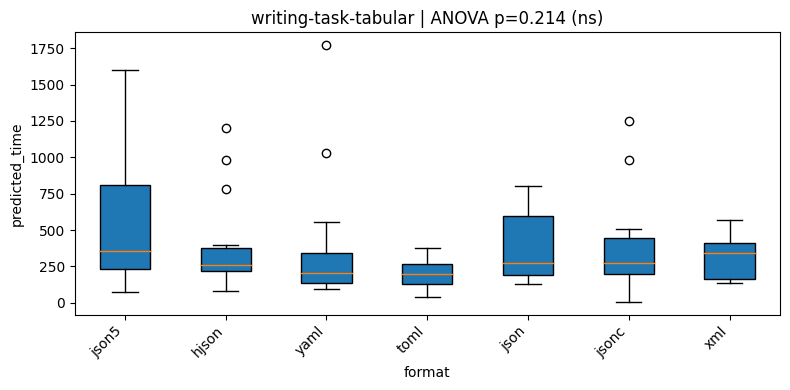

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.201259,ANOVA,0.213504,False,[]


In [13]:
summary_writing_ptime = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='predicted_time',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_ptime

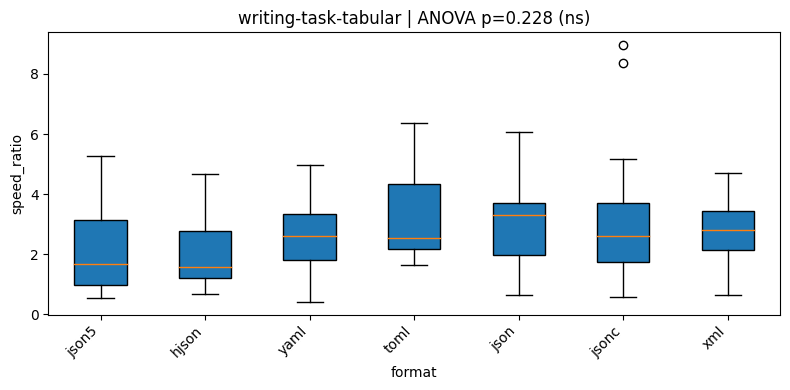

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.395421,ANOVA,0.228037,False,[]


In [14]:
summary_writing_sr = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='speed_ratio',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_sr

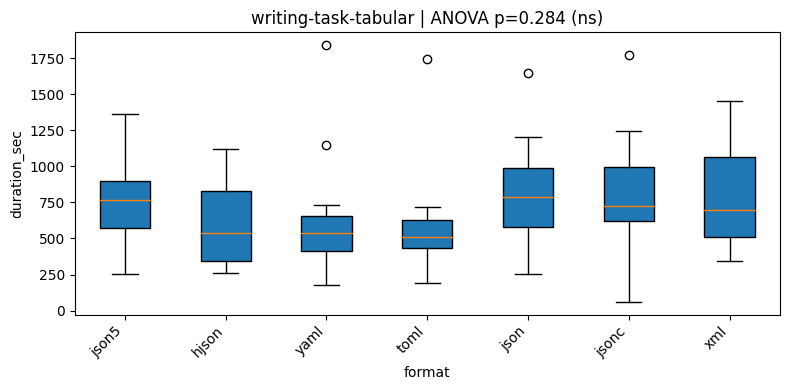

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.939824,ANOVA,0.284465,False,[]


In [15]:
summary_writing_atime = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='duration_sec',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_atime

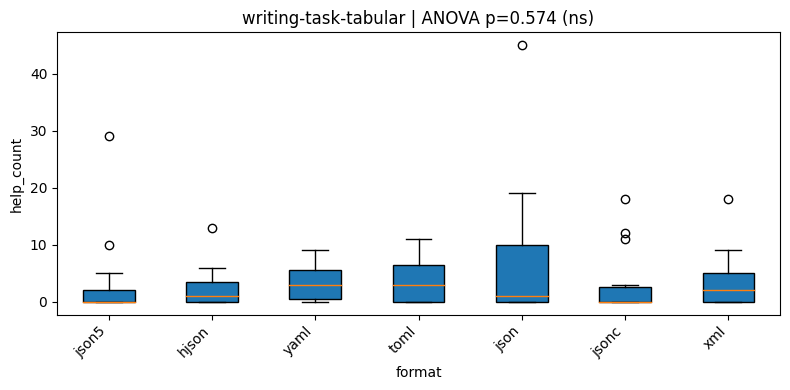

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-tabular,0.441093,ANOVA,0.574159,False,[]


In [16]:
summary_writing_help = analyze_metric_differences(
    df=df_tab_norm,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_help

In [77]:
import re
import pandas as pd
from scipy.stats import zscore
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMResults

def add_speed_zscore(
    df: pd.DataFrame,
    participant_col: str = 'participant_id',
    speed_col: str = 'speed_ratio'
) -> pd.DataFrame:
    df2 = df.copy()
    df2['speed_zscore'] = (
        df2
        .groupby(participant_col)[speed_col]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )
    return df2

def fit_mixed_effects_speed(
    df: pd.DataFrame,
    speed_col: str = 'speed_zscore',
    format_col: str = 'format',
    participant_col: str = 'participant_id'
) -> MixedLMResults:
    df2 = df.copy()
    df2[format_col] = df2[format_col].astype('category')
    formula = f"{speed_col} ~ C({format_col})"
    model = smf.mixedlm(formula, df2, groups=df2[participant_col])
    return model.fit()

# 先生成 z-score
df_speed_z = add_speed_zscore(
    df_tab_norm,
    participant_col='participantId',
    speed_col='speed_ratio'
)

# 然后用 speed_zscore 拟合
mixed_res = fit_mixed_effects_speed(
    df_speed_z,
    speed_col='speed_ratio',
    format_col='format',
    participant_col='participantId'
)
print(mixed_res.summary())


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   speed_ratio
No. Observations:    106       Method:               REML       
No. Groups:          106       Scale:                1.2418     
Min. group size:     1         Log-Likelihood:       -195.0124  
Max. group size:     1         Converged:            Yes        
Mean group size:     1.0                                        
----------------------------------------------------------------
                   Coef.    Std.Err.     z   P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept          2.122         0.407 5.216 0.000  1.325  2.920
C(format)[T.json]  0.808         0.558 1.446 0.148 -0.287  1.902
C(format)[T.json5] 0.111         0.575 0.193 0.847 -1.017  1.239
C(format)[T.jsonc] 1.221         0.575 2.121 0.034  0.093  2.348
C(format)[T.toml]  1.187         0.586 2.027 0.043  0.039  2.335
C(format)[T.xml]   0.693         0.575 

## reading/modifying result

In [17]:
import re
import pandas as pd

def aggregate_tasks_with_format(
    df: pd.DataFrame,
    participant_col: str = 'participant_id',
    task_col: str = 'task',
    format_col: str = 'format',
    metrics: list = ['duration_sec', 'help_count']
) -> pd.DataFrame:
    """
    对形如 <prefix>-<format>-<number> 的子任务：
      1) 清理中间 '-<format>'，如 reading-task-tabular-json5-1 → reading-task-tabular-1
      2) 生成汇总行（<prefix>），将同 participant+format 下所有数字后缀子任务的 metrics 求和，
         并保留 format

    参数:
      df            包含 participant_id, task, format, metrics 列的 DataFrame
      participant_col: 列名，参与者 ID
      task_col:        列名，任务名称
      format_col:      列名，格式名称
      metrics:         需要聚合的列

    返回:
      DataFrame：包含原始子任务行 + 聚合行，聚合行的 task 列为 prefix（去掉数字后缀）
    """
    df = df.copy()
    # 1) 去掉中间 '-<format>'，仅针对末尾带数字后缀的任务
    def strip_format(task, fmt):
        # pattern: -<fmt> before -number
        return re.sub(fr"-{re.escape(fmt)}(?=-\d+$)", "", task)
    df[task_col] = df.apply(lambda row: strip_format(row[task_col], str(row[format_col])), axis=1)

    # 2) 筛选出带数字后缀的子任务
    mask = df[task_col].str.contains(r"-\d+$", regex=True)
    sub = df[mask].copy()

    # 3) 计算 prefix = 去掉尾部 '-number'
    sub_prefix = sub.copy()
    sub_prefix[task_col] = sub_prefix[task_col].str.replace(r"-\d+$", "", regex=True)

    # 4) 按 participant_id + format + prefix 聚合 metrics
    agg = (
        sub_prefix
        .groupby([participant_col, format_col, task_col], as_index=False)[metrics]
        .sum()
    )

    # 5) 合并原始行和聚合行
    result = pd.concat([df, agg], ignore_index=True, sort=False)
    return result

# 示例用法：
# df_reading_clean = aggregate_tasks_with_format(df_reading)
# df_mod_clean     = aggregate_tasks_with_format(df_modifying)




df_reading_clean = aggregate_tasks_with_format(
    df_reading,
    participant_col='participantId',
    task_col='task',
    format_col = 'format',
    metrics=['duration_sec','help_count']
)

df_modifying_clean = aggregate_tasks_with_format(
    df_modifying_tabular,
    participant_col='participantId',
    task_col='task',
    format_col = 'format',
    metrics=['duration_sec','help_count']
)

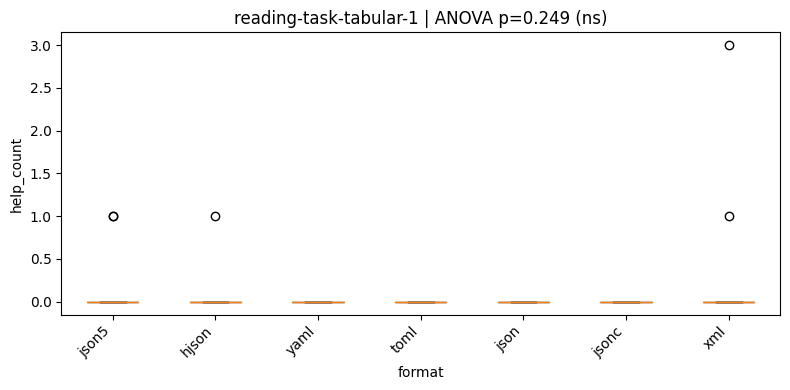

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


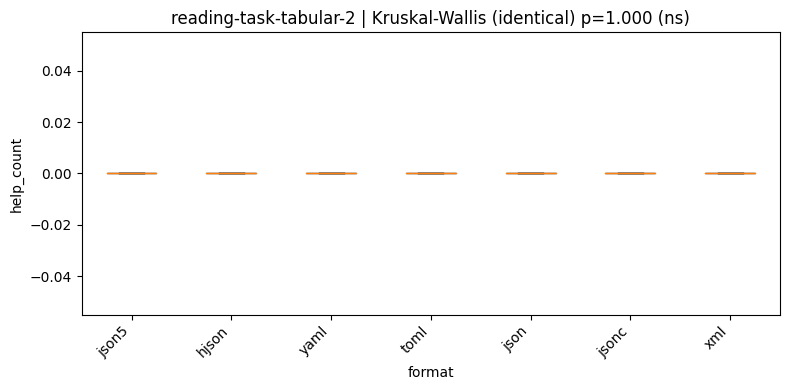

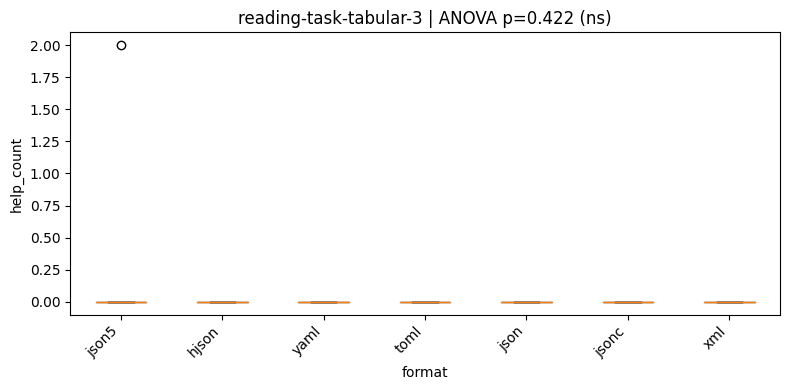

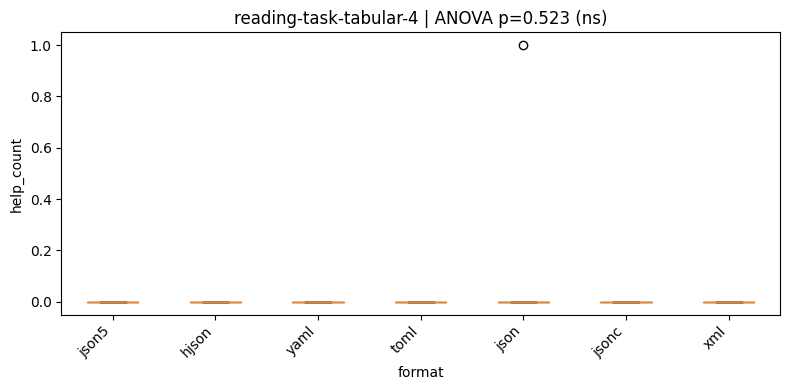

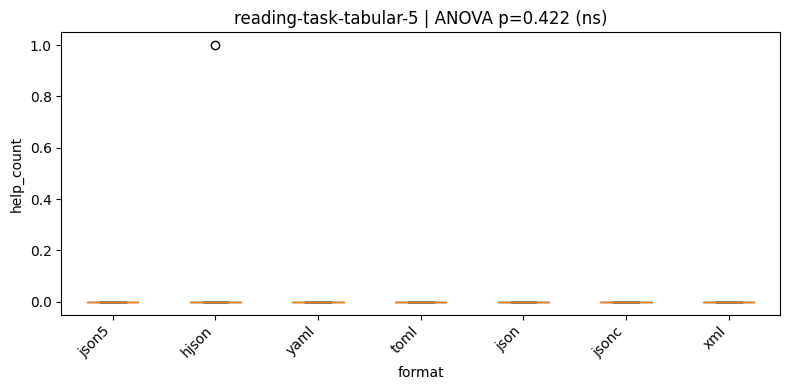

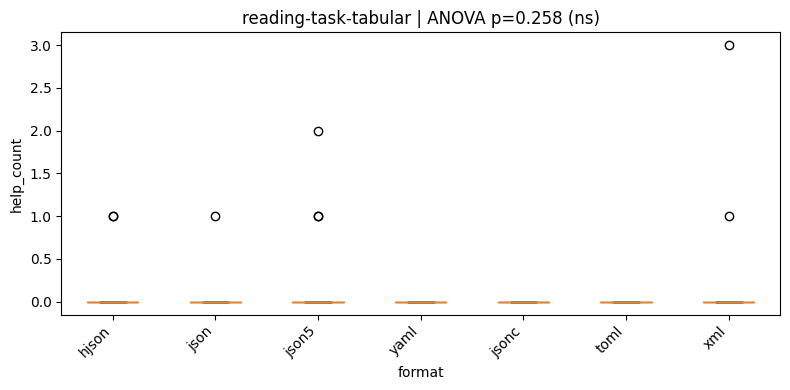

,task,homogeneity_p,test,test_p,significant,posthoc
0,reading-task-tabular-1,0.249339,ANOVA,0.249339,False,[]
1,reading-task-tabular-2,NaN,Kruskal-Wallis (identical),1.000000,False,[]
2,reading-task-tabular-3,0.422121,ANOVA,0.422121,False,[]
3,reading-task-tabular-4,0.522879,ANOVA,0.522879,False,[]
4,reading-task-tabular-5,0.422121,ANOVA,0.422121,False,[]
5,reading-task-tabular,0.257991,ANOVA,0.257991,False,[]


In [18]:
summary_reading_help = analyze_metric_differences(
    df=df_reading_clean,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_reading_help

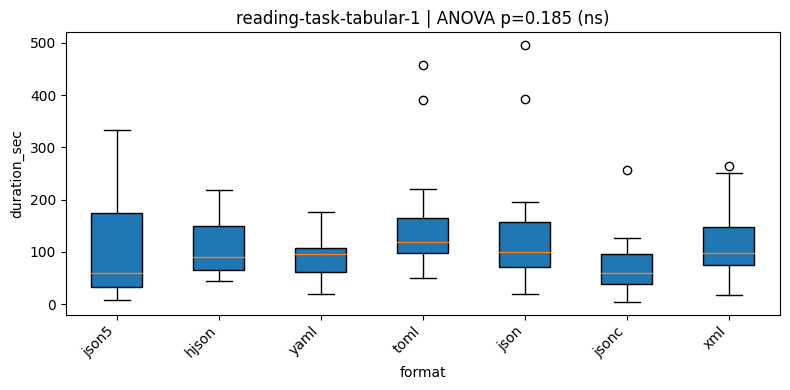

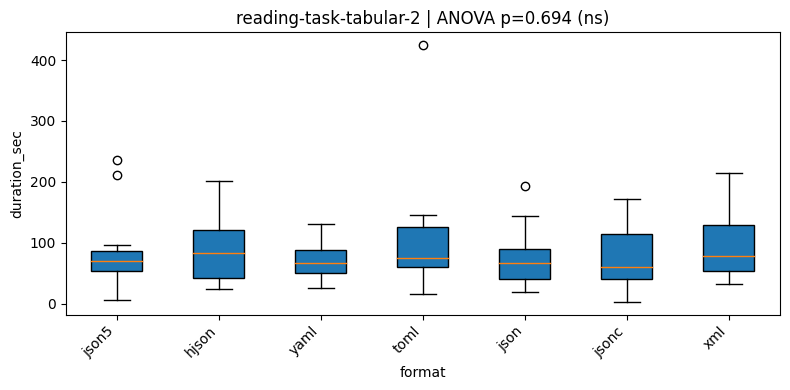

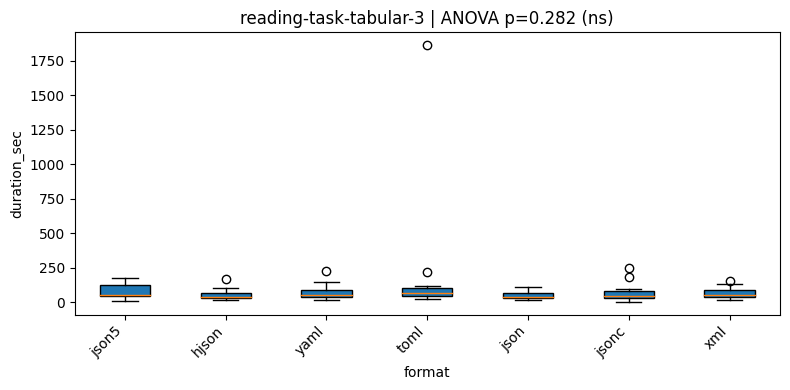

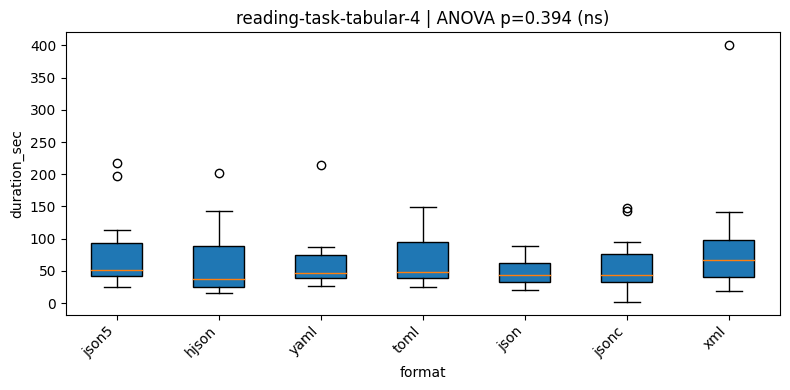

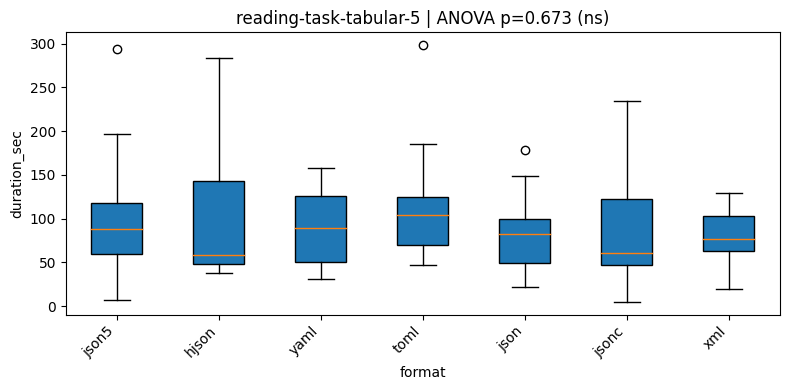

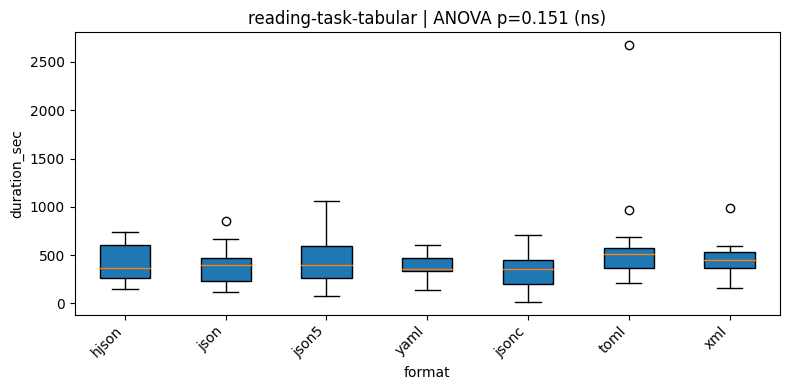

,task,homogeneity_p,test,test_p,significant,posthoc
0,reading-task-tabular-1,0.338326,ANOVA,0.185309,False,[]
1,reading-task-tabular-2,0.732178,ANOVA,0.694480,False,[]
2,reading-task-tabular-3,0.348505,ANOVA,0.282461,False,[]
3,reading-task-tabular-4,0.558429,ANOVA,0.394428,False,[]
4,reading-task-tabular-5,0.495129,ANOVA,0.672755,False,[]
5,reading-task-tabular,0.465146,ANOVA,0.151016,False,[]


In [19]:
summary_reading_time = analyze_metric_differences(
    df=df_reading_clean,
    task_col='task',
    group_col='format',
    metric_col='duration_sec',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_reading_time

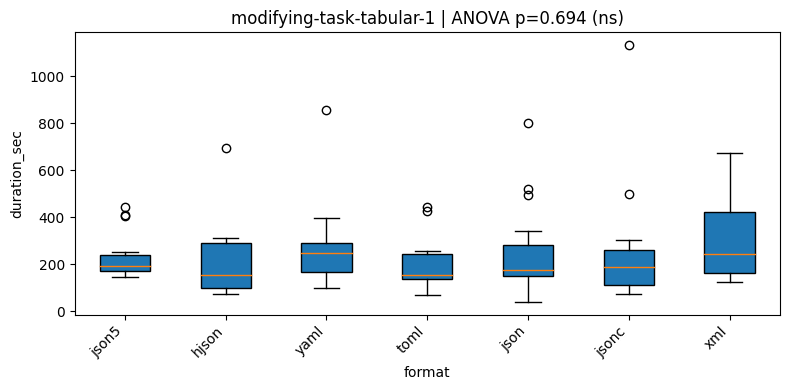

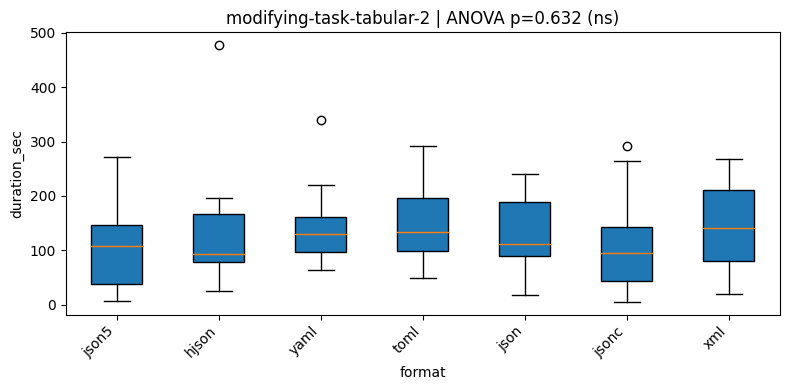

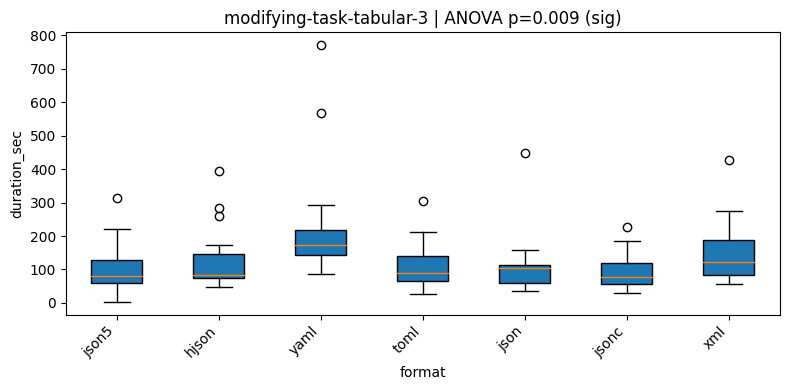

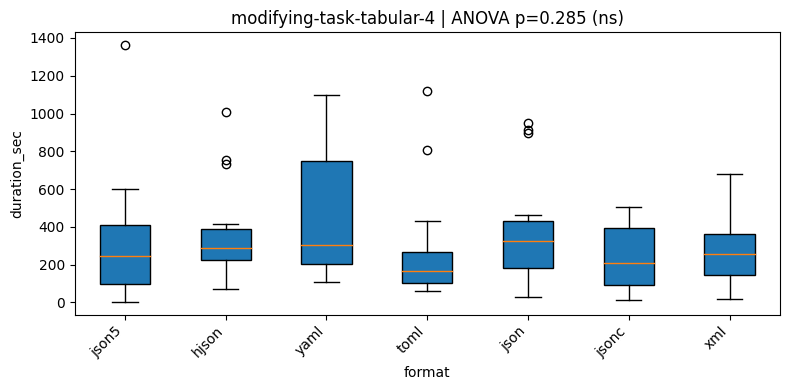

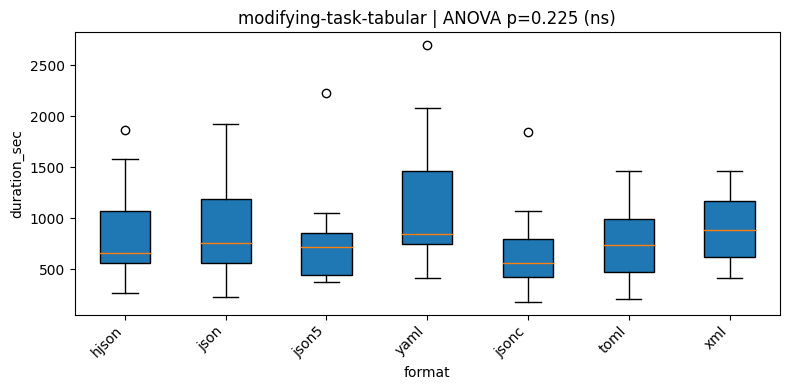

,task,homogeneity_p,test,test_p,significant,posthoc
0,modifying-task-tabular-1,0.789678,ANOVA,0.693573,False,[]
1,modifying-task-tabular-2,0.988812,ANOVA,0.632126,False,[]
2,modifying-task-tabular-3,0.554342,ANOVA,0.009062,True,"[json vs yaml, json5 vs yaml, jsonc vs yaml, t..."
3,modifying-task-tabular-4,0.740686,ANOVA,0.285302,False,[]
4,modifying-task-tabular,0.830471,ANOVA,0.225203,False,[]


In [20]:
summary_modifying_time = analyze_metric_differences(
    df=df_modifying_clean,
    task_col='task',
    group_col='format',
    metric_col='duration_sec',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_modifying_time

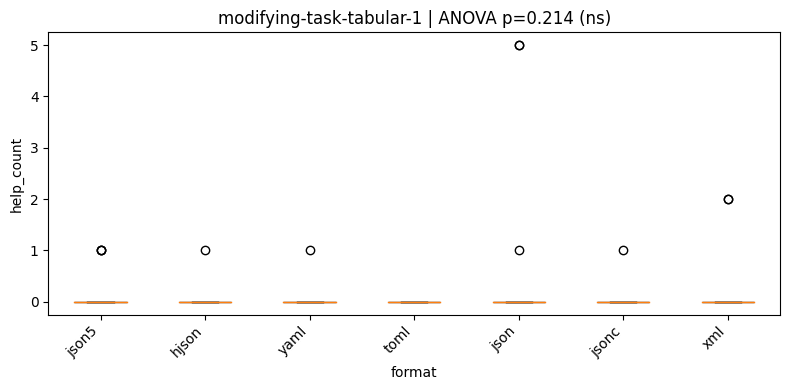

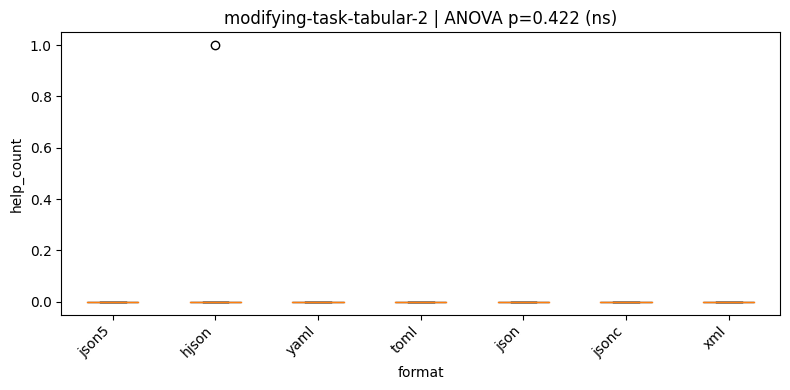

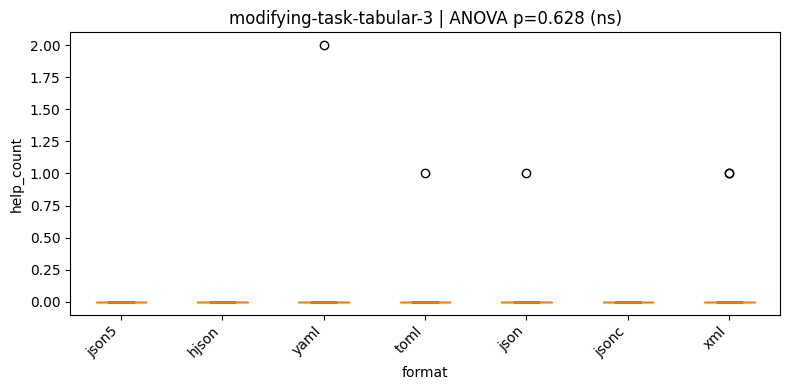

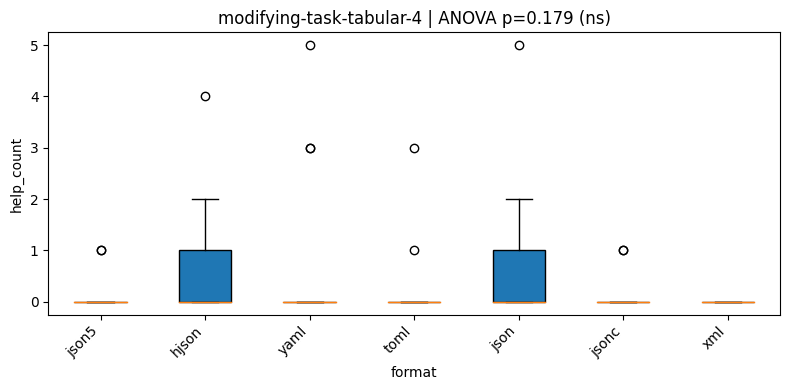

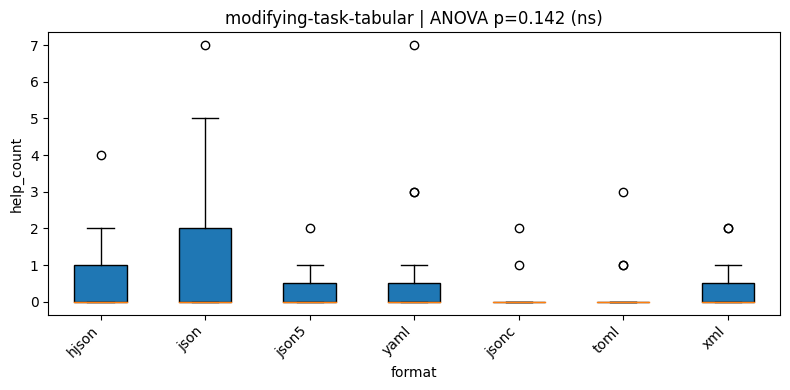

,task,homogeneity_p,test,test_p,significant,posthoc
0,modifying-task-tabular-1,0.214148,ANOVA,0.214148,False,[]
1,modifying-task-tabular-2,0.422121,ANOVA,0.422121,False,[]
2,modifying-task-tabular-3,0.627621,ANOVA,0.627621,False,[]
3,modifying-task-tabular-4,0.178922,ANOVA,0.178922,False,[]
4,modifying-task-tabular,0.141615,ANOVA,0.141615,False,[]


In [21]:
summary_modifying_help = analyze_metric_differences(
    df=df_modifying_clean,
    task_col='task',
    group_col='format',
    metric_col='help_count',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_modifying_help

In [14]:
df_reading_clean = clean_task_column(df_reading, task_col='task', format_col='format')
df_reading_clean

,participantId,task,format,response,start_time,end_time,duration_sec,help_count
0,64457bc906c125cebd4bf66b,reading-task-tabular-json5-1,json5,9,1746560020255,1746560035079,14.824,0
1,64457bc906c125cebd4bf66b,reading-task-tabular-json5-2,json5,quiz2,1746560041376,1746560113842,72.466,0
2,64457bc906c125cebd4bf66b,reading-task-tabular-json5-3,json5,4,1746560124736,1746560149342,24.606,0
3,64457bc906c125cebd4bf66b,reading-task-tabular-json5-4,json5,Bob,1746560157160,1746560183570,26.410,0
4,64457bc906c125cebd4bf66b,reading-task-tabular-json5-5,json5,[Eve],1746560189284,1746560285710,96.426,0
...,...,...,...,...,...,...,...,...
525,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-1,hjson,87,1746233727732,1746233901525,173.793,0
526,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-2,hjson,quiz2,1746233907262,1746233960037,52.775,0
527,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-3,hjson,4,1746233966788,1746233995855,29.067,0
528,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-4,hjson,Bob,1746234000908,1746234202457,201.549,0


## reading

In [22]:
def _normalize(val: any) -> str:
    """
    基础规范化：
      - 转成 str
      - 折叠空白
      - strip
      - lower
    """
    s = str(val)
    s = re.sub(r"\s+", " ", s).strip()
    return s.lower()


def annotate_reading_correctness_exact(
    df: pd.DataFrame,
    correct_answers: dict,
    task_col: str     = 'task',
    format_col: str   = 'format',
    response_col: str = 'response'
) -> pd.DataFrame:
    """
    精确匹配阅读题答案：
    - correct_answers[key] 为单值或列表，值可以是类似 '[Bob, Eve]' 或 'Alice'
    - 只当用户作答完全等于某一选项（单选或多选整体）时，才算正确

    对于用户 response：
      - 若为 list/tuple，则视为多选，multiple_norm = ','.join(norm(item))
      - 若单值或字符串，则单选，item_norm = norm(item)
    将正确答案列表中的每一项：
      - 把外层方括号去掉得到 inner = strip_brackets(ans)
      - norm(inner) 作为候选 multi_norm
      - norm(ans) 作为候选 single_norm

    匹配规则：
      - 如果是多选（len>1），比较 multi_norm 是否在候选 multi_norms
      - 如果是单选，则比较 item_norm 是否在候选 single_norms

    返回含新增两列的 DataFrame：
      - correct_answer: 原始候选拼接字符串
      - correct: 0/1
    """
    df2 = df.copy()
    ans_col = []
    flag_col = []

    for _, row in df2.iterrows():
        # 清理 key
        orig_task = str(row[task_col])
        fmt = str(row[format_col])
        clean_key = re.sub(fr"-{re.escape(fmt)}(?=-\d+$)", "", orig_task)
        raw = correct_answers.get(clean_key, correct_answers.get(orig_task, []))
        if not isinstance(raw, (list, tuple)):
            raw = [raw]
        # display
        ans_col.append(", ".join(str(x) for x in raw)
        )
        # build candidate norms
        single_norms = set()
        multi_norms  = set()
        for cand in raw:
            cand_str = str(cand)
            # inner = remove outer brackets
            inner = re.sub(r"^\s*\[|\]\s*$", "", cand_str)
            # normalize
            sn = _normalize(inner)
            single_norms.add(sn)
            # multi_norm uses commas
            parts = [_normalize(x) for x in inner.split(',')]
            mn = ",".join(parts)
            multi_norms.add(mn)

        # process response
        resp = row[response_col]
        # if list/tuple -> multi, else single
        if isinstance(resp, (list, tuple)):
            parts = [_normalize(x) for x in resp]
            resp_norm = ",".join(parts)
            hit = resp_norm in multi_norms
        else:
            r = str(resp)
            # remove brackets if any
            r_inner = re.sub(r"^\s*\[|\]\s*$", "", r)
            r_norm = _normalize(r_inner)
            hit = r_norm in single_norms
        flag_col.append(int(hit))

    df2['correct_answer'] = ans_col
    df2['correct'] = flag_col
    return df2




correct_answers = {
    'reading-task-tabular-1': 87,
    'reading-task-tabular-2': 'quiz2',
    'reading-task-tabular-3': 4,
    'reading-task-tabular-4': 'Bob',
    'reading-task-tabular-5': ['[Bob, Eve]', '[Alice]']
}

df_reading_clean = clean_task_column(df_reading, task_col='task', format_col='format')

df_result = annotate_reading_correctness_exact(
    df_reading_clean,
    correct_answers,
    task_col='task',
    format_col='format',
    response_col='response'
)
df_result



,participantId,task,format,response,start_time,end_time,duration_sec,help_count,correct_answer,correct
0,64457bc906c125cebd4bf66b,reading-task-tabular-json5-1,json5,9,1746560020255,1746560035079,14.824,0,87,0
1,64457bc906c125cebd4bf66b,reading-task-tabular-json5-2,json5,quiz2,1746560041376,1746560113842,72.466,0,quiz2,1
2,64457bc906c125cebd4bf66b,reading-task-tabular-json5-3,json5,4,1746560124736,1746560149342,24.606,0,4,1
3,64457bc906c125cebd4bf66b,reading-task-tabular-json5-4,json5,Bob,1746560157160,1746560183570,26.410,0,Bob,1
4,64457bc906c125cebd4bf66b,reading-task-tabular-json5-5,json5,[Eve],1746560189284,1746560285710,96.426,0,"[Bob, Eve], [Alice]",0
...,...,...,...,...,...,...,...,...,...,...
525,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-1,hjson,87,1746233727732,1746233901525,173.793,0,87,1
526,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-2,hjson,quiz2,1746233907262,1746233960037,52.775,0,quiz2,1
527,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-3,hjson,4,1746233966788,1746233995855,29.067,0,4,1
528,6675c40cdc52b37294f0514e,reading-task-tabular-hjson-4,hjson,Bob,1746234000908,1746234202457,201.549,0,Bob,1


In [23]:
def aggregate_tasks_with_format(
    df: pd.DataFrame,
    participant_col: str = 'participant_id',
    task_col:        str = 'task',
    format_col:      str = 'format',
    sum_cols:        list = None,
    mean_cols:       list = None
) -> pd.DataFrame:
    """
    对形如 <prefix>-<format>-<number> 的子任务做聚合：
      1) 清理中间 '-<format>'，如 'reading-task-tabular-json5-1' → 'reading-task-tabular-1'
      2) 生成汇总行（<prefix>），按 participant+format 聚合：
         - 对 sum_cols 列做 sum
         - 对 mean_cols 列做 mean
         并保留 format 列

    参数:
      df             原始 DataFrame，需包含 participant_col, task_col, format_col
      participant_col: 参与者 ID 列名
      task_col:        任务名称 列名
      format_col:      格式 列名
      sum_cols:        需要求和的列列表（如 ['duration_sec','help_count']）
      mean_cols:       需要取平均的列列表（如 ['correct']）

    返回:
      包含原始子任务行 + 汇总行的 DataFrame，汇总行的 task_col 为 prefix（去掉数字后缀）
    """
    df2 = df.copy()
    sum_cols = sum_cols or []
    mean_cols = mean_cols or []

    # 1) 清理 '-<format>'
    def _strip_fmt(task, fmt):
        return re.sub(fr"-{re.escape(fmt)}(?=-\d+$)", "", task)
    df2[task_col] = df2.apply(
        lambda r: _strip_fmt(r[task_col], str(r[format_col])),
        axis=1
    )

    # 2) 筛选子任务
    mask = df2[task_col].str.contains(r"-\d+$", regex=True)
    sub = df2[mask].copy()

    # 3) 构造 prefix
    sub_prefix = sub.copy()
    sub_prefix[task_col] = sub_prefix[task_col].str.replace(r"-\d+$", "", regex=True)

    # 4) 构建聚合映射
    agg_map = {c: 'sum' for c in sum_cols}
    agg_map.update({c: 'mean' for c in mean_cols})

    # 5) 聚合
    agg = (
        sub_prefix
        .groupby([participant_col, format_col, task_col], as_index=False)
        .agg(agg_map)
    )

    # 6) 合并并返回
    result = pd.concat([df2, agg], ignore_index=True, sort=False)
    return result

df_agg = aggregate_tasks_with_format(
    df_result,
    participant_col='participantId',
    task_col='task',
    format_col='format',
    sum_cols=['duration_sec','help_count'],
    mean_cols=['correct']
)
df_agg

,participantId,task,format,response,start_time,end_time,duration_sec,help_count,correct_answer,correct
0,64457bc906c125cebd4bf66b,reading-task-tabular-1,json5,9,1.746560e+12,1.746560e+12,14.824,0,87,0.0
1,64457bc906c125cebd4bf66b,reading-task-tabular-2,json5,quiz2,1.746560e+12,1.746560e+12,72.466,0,quiz2,1.0
2,64457bc906c125cebd4bf66b,reading-task-tabular-3,json5,4,1.746560e+12,1.746560e+12,24.606,0,4,1.0
3,64457bc906c125cebd4bf66b,reading-task-tabular-4,json5,Bob,1.746560e+12,1.746560e+12,26.410,0,Bob,1.0
4,64457bc906c125cebd4bf66b,reading-task-tabular-5,json5,[Eve],1.746560e+12,1.746560e+12,96.426,0,"[Bob, Eve], [Alice]",0.0
...,...,...,...,...,...,...,...,...,...,...
631,67f1a4f8dd44e7cd5adffa29,reading-task-tabular,json5,NaN,NaN,NaN,1056.874,0,NaN,1.0
632,67f1c7bd6f1c4a3d8deae02f,reading-task-tabular,toml,NaN,NaN,NaN,577.437,0,NaN,0.8
633,67f3619e16d4ca195fbd1bd0,reading-task-tabular,yaml,NaN,NaN,NaN,603.879,0,NaN,0.6
634,67f5bb69760b211cdfe8021c,reading-task-tabular,jsonc,NaN,NaN,NaN,173.583,0,NaN,0.8


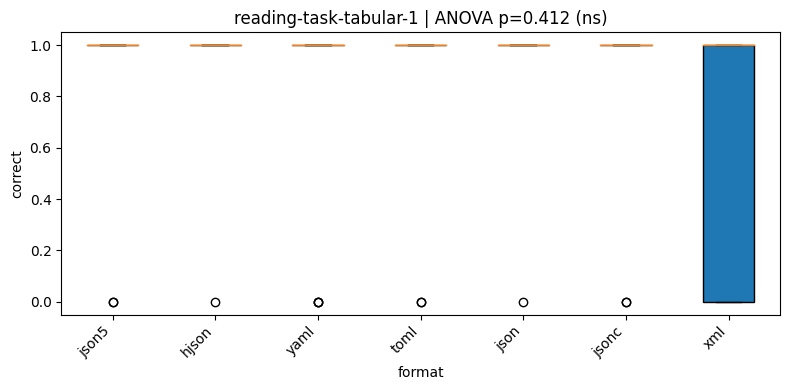

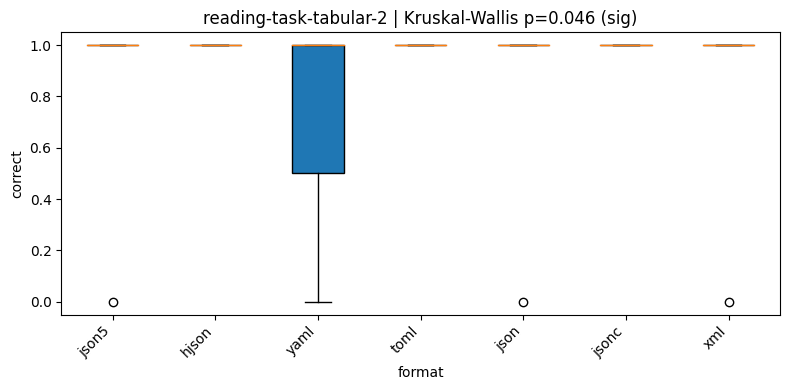

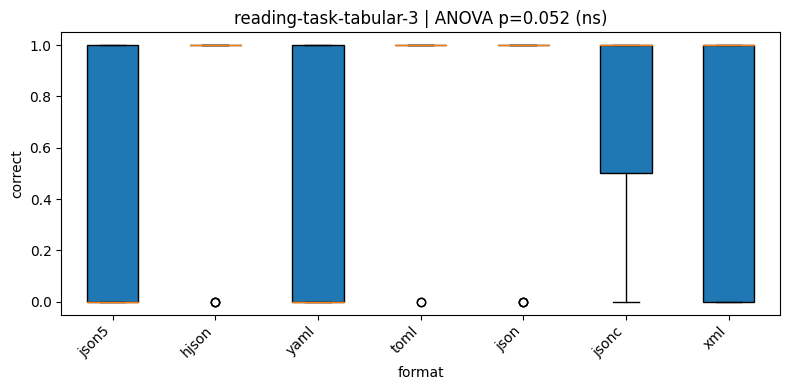

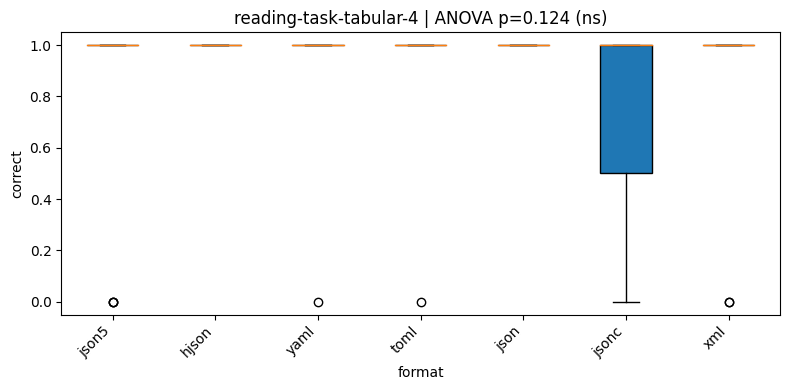

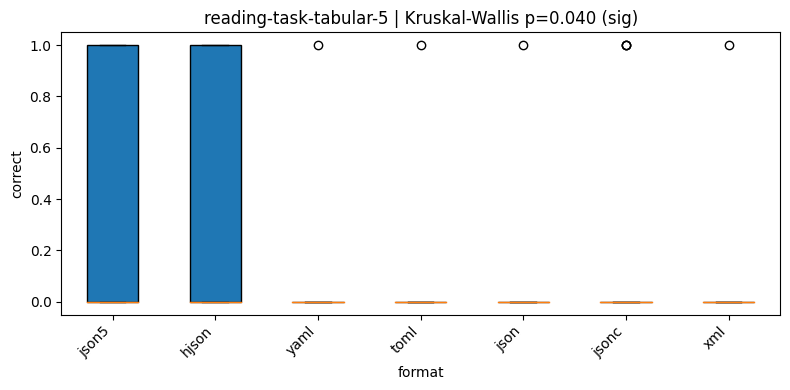

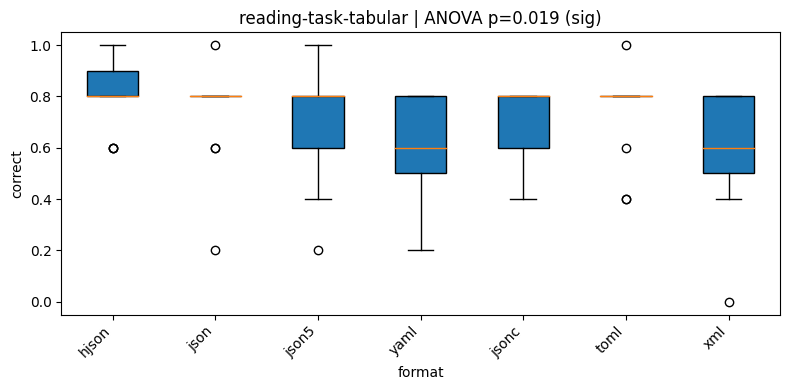

,task,homogeneity_p,test,test_p,significant,posthoc
0,reading-task-tabular-1,0.412305,ANOVA,0.412305,False,[]
1,reading-task-tabular-2,0.041199,Kruskal-Wallis,0.046440,True,[]
2,reading-task-tabular-3,0.155270,ANOVA,0.052135,False,[]
3,reading-task-tabular-4,0.124492,ANOVA,0.124492,False,[]
4,reading-task-tabular-5,0.035401,Kruskal-Wallis,0.040486,True,[]
5,reading-task-tabular,0.337565,ANOVA,0.018665,True,"[hjson vs xml, hjson vs yaml]"


In [24]:
summary_writing_correct = analyze_metric_differences(
    df=df_agg,
    task_col='task',
    group_col='format',
    metric_col='correct',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_writing_correct

## quiz

In [25]:
from quiz_evaluator import evaluate_quiz_answers_from_tutorial

df_quiz = evaluate_quiz_answers_from_tutorial(all_data)
df_quiz

,participantId,format,quiz_key,correct_answer,user_final_answer,correct,num_wrong_attempts,all_wrong_attempts_list,all_wrong_attempts_frequency,wrong_choice_distribution,wrong_choice_count
0,64457bc906c125cebd4bf66b,json5,tutorial-json5-part1,[D],[D],1,3,"[[B, C, D], [B], [B, D]]","{'B': 3, 'C': 1, 'D': 2}","{'B': 3, 'C': 1}",4
1,64457bc906c125cebd4bf66b,json5,tutorial-json5-part2,"[A, B, C, D]","[C, B]",0,5,"[[B], [D], [C], [C, A], [C, B]]","{'B': 2, 'D': 1, 'C': 3, 'A': 1}",{},0
2,6697c8b6d9d7baa7edd8c4d3,hjson,tutorial-hjson-part1,"[A, C]","[A, C]",1,3,"[[B], [A, C, D], [A, D]]","{'B': 1, 'A': 2, 'C': 1, 'D': 2}","{'B': 1, 'D': 2}",3
3,6697c8b6d9d7baa7edd8c4d3,hjson,tutorial-hjson-part2,"[A, B, C, D]","[B, D, C, A]",1,1,"[[B, D]]","{'B': 1, 'D': 1}",{},0
4,67e25388d573ec2d5f1c8442,yaml,tutorial-yaml-part1,"[B, C, D]","[C, D, B]",1,0,[],{},{},0
...,...,...,...,...,...,...,...,...,...,...,...
207,67f1c7bd6f1c4a3d8deae02f,toml,tutorial-toml-part2,"[A, B, D]","[A, B, D]",1,0,[],{},{},0
208,67adb27bd5f5776fcb16da62,hjson,tutorial-hjson-part1,"[A, C]","[A, C]",1,3,"[[A, B], [B, D], [B, D]]","{'A': 1, 'B': 3, 'D': 2}","{'B': 3, 'D': 2}",5
209,67adb27bd5f5776fcb16da62,hjson,tutorial-hjson-part2,"[A, B, C, D]","[D, C, B, A]",1,1,"[[D, C]]","{'D': 1, 'C': 1}",{},0
210,6675c40cdc52b37294f0514e,hjson,tutorial-hjson-part1,"[A, C]","[D, C]",0,5,"[[C], [C, B], [C, A, D], [A, D], [D, C]]","{'C': 4, 'B': 1, 'A': 2, 'D': 3}","{'B': 1, 'D': 3}",4


In [38]:
import re
import pandas as pd

def aggregate_quiz_parts(
    df: pd.DataFrame,
    participant_col: str = 'participantId',
    format_col: str = 'format',
    task_col: str = 'quiz_key',
    sum_cols: list = None,
    mean_cols: list = None
) -> pd.DataFrame:
    """
    将 quiz_key 中的 part1/part2 聚合为不带后缀的基准任务并追加到原表：
      tutorial-json5-part1 & tutorial-json5-part2 -> tutorial-json5

    对于聚合后的每条记录：
      - 对 sum_cols 指定的列做求和
      - 对 mean_cols 指定的列做平均

    参数:
      df            原始 quiz DataFrame，需包含 participant_col, format_col, task_col
      participant_col: 参与者 ID 列名
      format_col:      格式 列名
      task_col:        任务列名（如 'quiz_key'），形如 'tutorial-json5-part1'
      sum_cols:        需要合并求和的列名列表（如 ['num_wrong_attempts','wrong_choice_count']）
      mean_cols:       需要合并取平均的列名列表（如 ['correct']）

    返回:
      原始行 + 聚合行组成的 DataFrame，聚合行的 task_col 为 'tutorial-json5',
      sum_cols 做 sum，mean_cols 做 mean。
    """
    df2 = df.copy()
    sum_cols = sum_cols or []
    mean_cols = mean_cols or []

    # 1) 计算基准任务名：去掉末尾 '-part1' 或 '-part2'
    base = df2[task_col].str.replace(r'-part[12]$', '', regex=True)

    # 2) 构建聚合映射
    agg_map = {c: 'sum' for c in sum_cols}
    agg_map.update({c: 'mean' for c in mean_cols})

    # 3) 按 participant, format, base 进行聚合
    agg = (
        df2.assign(**{'_base': base})
           .groupby([participant_col, format_col, '_base'], as_index=False)
           .agg(agg_map)
           .rename(columns={'_base': task_col})
    )

    # 4) 合并 原始行 + 聚合行，不改变原始数据
    combined = pd.concat([df2, agg], ignore_index=True, sort=False)
    return combined


def summarize_quiz_parts(
    df: pd.DataFrame,
    participant_col: str = 'participantId',
    format_col:    str = 'format',
    task_col:      str = 'quiz_key',
    sum_cols:      list = None,
    mean_cols:     list = None
) -> pd.DataFrame:
    """
    只提取 quiz_key 中 part1/part2 聚合后的基准任务行：
      tutorial-json5-part1 & tutorial-json5-part2 -> tutorial-json5

    聚合规则：
      - 对 sum_cols 指定的列做求和
      - 对 mean_cols 指定的列做平均

    返回一个 DataFrame，列为:
      [participant_col, format_col, task_col] + sum_cols + mean_cols
    其中 task_col 已被替换成去掉 '-part1/2' 的基准任务名。
    """
    df2 = df.copy()
    sum_cols  = sum_cols or []
    mean_cols = mean_cols or []

    # 1) 先生成“基准任务名”：去掉尾部 '-part1' 或 '-part2'
    base = df2[task_col].str.replace(r'-part[12]$', '', regex=True)

    # 2) 构建聚合映射
    agg_map = {c: 'sum'  for c in sum_cols}
    agg_map.update({c: 'mean' for c in mean_cols})

    # 3) 分组并聚合，只保留汇总行
    agg = (
        df2
        .assign(_base=base)
        .groupby([participant_col, format_col, '_base'], as_index=False)
        .agg(agg_map)
        .rename(columns={'_base': task_col})
    )

    # 4) 返回聚合结果
    return agg


df_quiz_agg = aggregate_quiz_parts(
    df_quiz,
    participant_col='participantId',
    format_col='format',
    task_col='quiz_key',
    sum_cols=['num_wrong_attempts', 'wrong_choice_count'],
    mean_cols=['correct']
)


df_quiz_summary = summarize_quiz_parts(
    df_quiz,
    participant_col='participantId',
    format_col='format',
    task_col='quiz_key',
    sum_cols=['num_wrong_attempts','wrong_choice_count'],
    mean_cols=['correct']
)

df_quiz_summary

,participantId,format,quiz_key,num_wrong_attempts,wrong_choice_count,correct
0,56cb8858edf8da000b6df354,hjson,tutorial-hjson,0,0,1.0
1,57c357770e6a1f00015f6038,json,tutorial-json,1,1,1.0
2,5b68c9eb87af310001584803,json5,tutorial-json5,3,2,1.0
3,5d30dfa68b1523000134878f,json,tutorial-json,3,6,1.0
4,5d766978f47e6200019a2acf,yaml,tutorial-yaml,2,1,1.0
...,...,...,...,...,...,...
101,67f1a4f8dd44e7cd5adffa29,json5,tutorial-json5,3,5,1.0
102,67f1c7bd6f1c4a3d8deae02f,toml,tutorial-toml,0,0,1.0
103,67f3619e16d4ca195fbd1bd0,yaml,tutorial-yaml,3,1,1.0
104,67f5bb69760b211cdfe8021c,jsonc,tutorial-jsonc,5,0,0.5


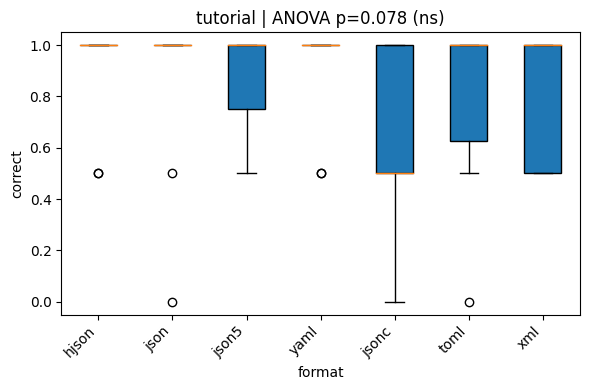

,task,homogeneity_p,test,test_p,significant,posthoc
0,tutorial,0.109688,ANOVA,0.078171,False,[]


In [39]:
import re
import pandas as pd

def analyze_metric_by_base_task(
    df: pd.DataFrame,
    task_col: str,
    format_col: str,
    metric_col: str,
    participant_col: str = None,
    alpha: float = 0.05,
    base_task_col: str = None,
    **analyze_kwargs
) -> pd.DataFrame:

    df2 = df.copy()
    # 1) 决定新列名
    if base_task_col is None:
        base_task_col = f"{task_col}_base"

    # 2) 去掉尾部 "-<format>"
    #    e.g. "tutorial-json5-part1" -> "tutorial-json5-part1" minus "-json5" -> "tutorial-part1"
    pattern = fr"-{re.escape(str(df2[format_col].iat[0]))}$"
    # but since each row may have different format, do apply:
    df2[base_task_col] = df2.apply(
        lambda r: re.sub(fr"-{re.escape(str(r[format_col]))}$", "", str(r[task_col])),
        axis=1
    )

    # 3) 调用你已有的 analyze_metric_differences
    #    记得把 clean_suffix 关掉，因为我们自己做了清理

    summary = analyze_metric_differences(
        df = df2,
        task_col   = base_task_col,
        group_col  = format_col,
        metric_col = metric_col,
        alpha      = alpha,
        clean_suffix = True,
        **analyze_kwargs
    )
    return summary

# 假设 df_quiz_combined 已含 tutorial-json5, tutorial-hjson ... 以及 correct
summary_quiz = analyze_metric_by_base_task(
    df            = df_quiz_summary,
    task_col      = 'quiz_key',
    format_col    = 'format',
    metric_col    = 'correct',
    alpha         = 0.05,
    # 如果 analyze_metric_differences 支持 figsize, 也可传进去：
    figsize       = (6,4)
)
summary_quiz



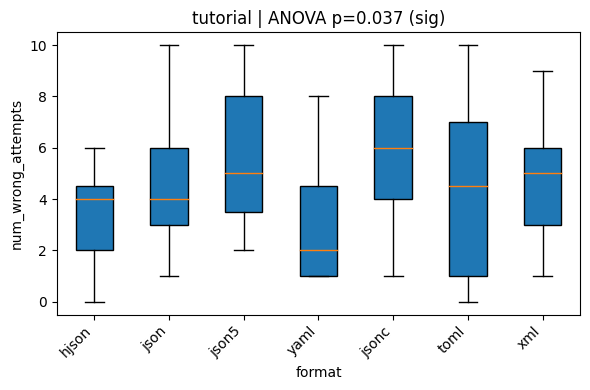

,task,homogeneity_p,test,test_p,significant,posthoc
0,tutorial,0.322153,ANOVA,0.037066,True,[]


In [40]:
summary_quiz_wrongAtp = analyze_metric_by_base_task(
    df            = df_quiz_summary,
    task_col      = 'quiz_key',
    format_col    = 'format',
    metric_col    = 'num_wrong_attempts',
    alpha         = 0.05,
    # 如果 analyze_metric_differences 支持 figsize, 也可传进去：
    figsize       = (6,4)
)
summary_quiz_wrongAtp

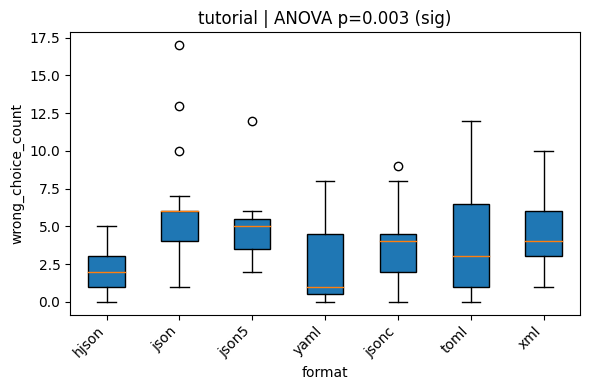

,task,homogeneity_p,test,test_p,significant,posthoc
0,tutorial,0.245063,ANOVA,0.00268,True,"[hjson vs json, json vs yaml]"


In [41]:
summary_quiz_wrongCho = analyze_metric_by_base_task(
    df            = df_quiz_summary,
    task_col      = 'quiz_key',
    format_col    = 'format',
    metric_col    = 'wrong_choice_count',
    alpha         = 0.05,
    # 如果 analyze_metric_differences 支持 figsize, 也可传进去：
    figsize       = (6,4)
)
summary_quiz_wrongCho

In [43]:
from quiz_evaluator import analyze_nasa_and_post_surveys

# 假设 all_data 已加载
df_nasa = analyze_nasa_and_post_surveys(all_data)
df_nasa['task']='nasaltx'
df_nasa

,participantId,format,startTime,endTime,duration_sec,mental-demand,physical-demand,temporal-demand,performance,effort,frustration,task
0,64457bc906c125cebd4bf66b,json5,1746562427809,1746562451027,23.218,93,11,55,10,75,94,nasaltx
1,6697c8b6d9d7baa7edd8c4d3,hjson,1745933947314,1745933980430,33.116,90,20,50,55,50,75,nasaltx
2,67e25388d573ec2d5f1c8442,yaml,1746148170240,1746148206380,36.140,90,100,70,0,95,5,nasaltx
3,67e5cf90b79d0874e1cf16b0,toml,1746147492250,1746147510048,17.798,97,90,92,78,99,61,nasaltx
4,67d00f24466a67ba7e41228e,toml,1745933364792,1745933382986,18.194,79,77,63,18,98,75,nasaltx
...,...,...,...,...,...,...,...,...,...,...,...,...
101,67ab650c320eccf6141d4010,jsonc,1746147500734,1746147519483,18.749,65,61,59,57,60,62,nasaltx
102,65fad673a546ab14baf2f8d3,json5,1745932106163,1745932137658,31.495,85,80,85,80,85,75,nasaltx
103,67f1c7bd6f1c4a3d8deae02f,toml,1746146632834,1746146718970,86.136,85,60,20,10,100,10,nasaltx
104,67adb27bd5f5776fcb16da62,hjson,1746147510098,1746147559334,49.236,85,75,85,60,80,55,nasaltx


In [45]:
import pandas as pd

def melt_tlx(
    df: pd.DataFrame,
    id_vars: list = None,
    tlx_vars: list = None,
    var_name: str = 'task',
    value_name: str = 'score'
) -> pd.DataFrame:
    """
    将 NASA-TLX 六个维度从宽表转成长表：
      mental-demand, physical-demand, temporal-demand,
      performance, effort, frustration
    会被融入一列 `var_name`，对应的数值列为 `value_name`。

    参数:
      df:        原始 DataFrame，需含上述维度列
      id_vars:   保留作为标识符的列列表，默认 ['participantId','format','startTime','endTime','duration_sec']
      tlx_vars:  待转换的列列表，默认上述六个
      var_name:  新列名，存放原列名
      value_name:新列名，存放原值

    返回:
      长表格式的 DataFrame，列为 id_vars + [var_name, value_name]
    """
    # 默认保留列
    if id_vars is None:
        id_vars = ['participantId', 'format', 'startTime', 'endTime', 'duration_sec']
    # 默认待融入列
    if tlx_vars is None:
        tlx_vars = [
            'mental-demand',
            'physical-demand',
            'temporal-demand',
            'performance',
            'effort',
            'frustration',
        ]
    # 使用 pandas.melt
    df_long = df.melt(
        id_vars=id_vars,
        value_vars=tlx_vars,
        var_name=var_name,
        value_name=value_name
    )
    return df_long

# Example:
df_long = melt_tlx(df_nasa)
df_long

,participantId,format,startTime,endTime,duration_sec,task,score
0,64457bc906c125cebd4bf66b,json5,1746562427809,1746562451027,23.218,mental-demand,93
1,6697c8b6d9d7baa7edd8c4d3,hjson,1745933947314,1745933980430,33.116,mental-demand,90
2,67e25388d573ec2d5f1c8442,yaml,1746148170240,1746148206380,36.140,mental-demand,90
3,67e5cf90b79d0874e1cf16b0,toml,1746147492250,1746147510048,17.798,mental-demand,97
4,67d00f24466a67ba7e41228e,toml,1745933364792,1745933382986,18.194,mental-demand,79
...,...,...,...,...,...,...,...
631,67ab650c320eccf6141d4010,jsonc,1746147500734,1746147519483,18.749,frustration,62
632,65fad673a546ab14baf2f8d3,json5,1745932106163,1745932137658,31.495,frustration,75
633,67f1c7bd6f1c4a3d8deae02f,toml,1746146632834,1746146718970,86.136,frustration,10
634,67adb27bd5f5776fcb16da62,hjson,1746147510098,1746147559334,49.236,frustration,55


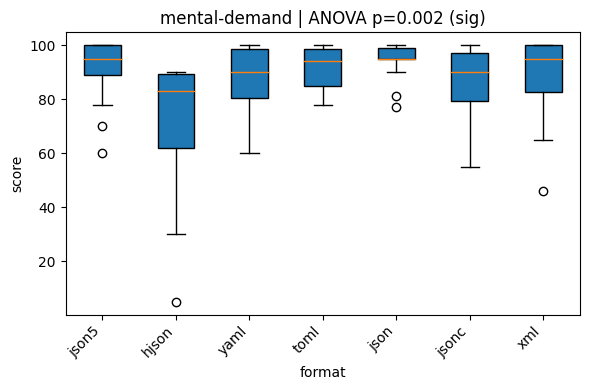

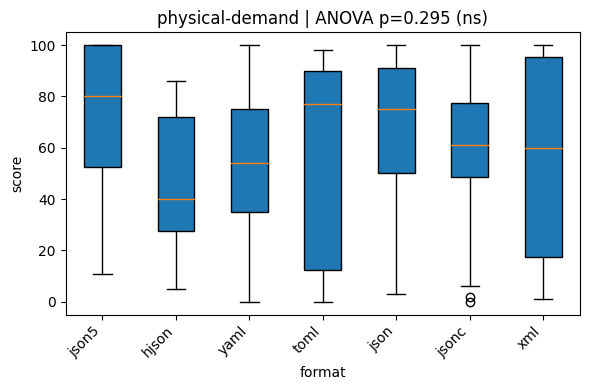

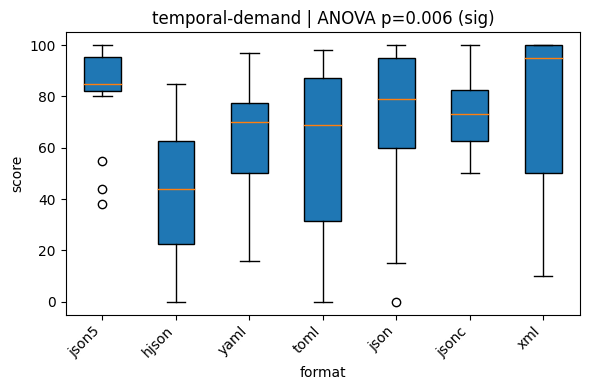

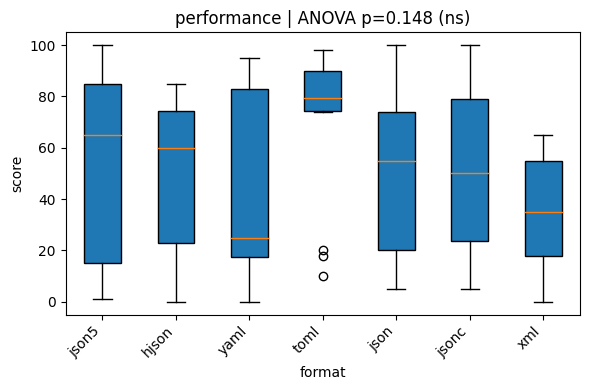

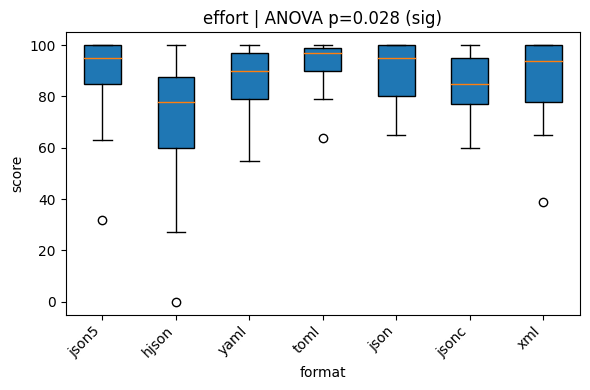

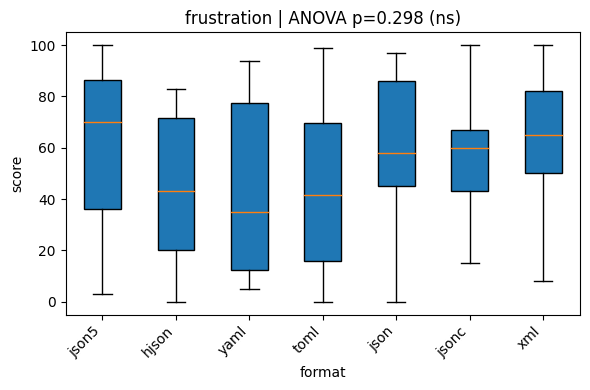

,task,homogeneity_p,test,test_p,significant,posthoc
0,mental-demand,0.151255,ANOVA,0.002115,True,"[hjson vs json, hjson vs json5, hjson vs toml,..."
1,physical-demand,0.659072,ANOVA,0.295161,False,[]
2,temporal-demand,0.238568,ANOVA,0.005873,True,"[hjson vs json, hjson vs json5, hjson vs jsonc]"
3,performance,0.495525,ANOVA,0.147673,False,[]
4,effort,0.230990,ANOVA,0.027573,True,"[hjson vs json, hjson vs toml]"
5,frustration,0.492372,ANOVA,0.297890,False,[]


In [49]:
df_long['score'] = pd.to_numeric(df_long['score'], errors='coerce')
summary_quiz_nasa = analyze_metric_by_base_task(
    df            = df_long,
    task_col      = 'task',
    format_col    = 'format',
    metric_col    = 'score',
    alpha         = 0.05,
    # 如果 analyze_metric_differences 支持 figsize, 也可传进去：
    figsize       = (6,4)
)
summary_quiz_nasa

In [54]:
from quiz_evaluator import extract_post_task_questions
import re
import pandas as pd



def clean_task_format(
    df: pd.DataFrame,
    task_col: str = 'task',
    format_col: str = 'format',
    new_col: str = None
) -> pd.DataFrame:
    """
    去掉 task_col 中紧跟在前缀后、尾部数字前的 '-<format>'。

    e.g. reading-task-tabular-json5-1 -> reading-task-tabular-1
    """
    df2 = df.copy()
    if new_col is None:
        new_col = task_col

    def _strip_fmt(row):
        t = str(row[task_col])
        fmt = re.escape(str(row[format_col]))
        # 匹配 -<fmt> 紧跟在后面并且前面后面都有 '-' 的那段
        return re.sub(fr"-{fmt}(?=-\d+$)", "", t)

    df2[new_col] = df2.apply(_strip_fmt, axis=1)
    return df2

df_post = extract_post_task_questions(all_data)

df_post_clean = clean_task_format(
    df_post,
    task_col='task',
    format_col='format'
)
df_post_clean


,participantId,format,task,startTime,endTime,duration_sec,difficulty,confidence
0,64457bc906c125cebd4bf66b,json5,writing-task-NL,1746559656954,1746559665762,8.808,1,7
1,64457bc906c125cebd4bf66b,json5,reading-task-tabular-1,1746560035266,1746560041262,5.996,4,4
2,64457bc906c125cebd4bf66b,json5,reading-task-tabular-2,1746560114063,1746560124630,10.567,4,3
3,64457bc906c125cebd4bf66b,json5,reading-task-tabular-3,1746560149554,1746560157039,7.485,5,3
4,64457bc906c125cebd4bf66b,json5,reading-task-tabular-4,1746560183791,1746560189177,5.386,3,5
...,...,...,...,...,...,...,...,...
1161,6675c40cdc52b37294f0514e,hjson,writing-task-tabular-hjson,1746235258159,1746235267565,9.406,5,4
1162,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-1,1746235543504,1746235551355,7.851,2,6
1163,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-2,1746235644408,1746235649351,4.943,2,6
1164,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-3,1746235723188,1746235729374,6.186,7,1


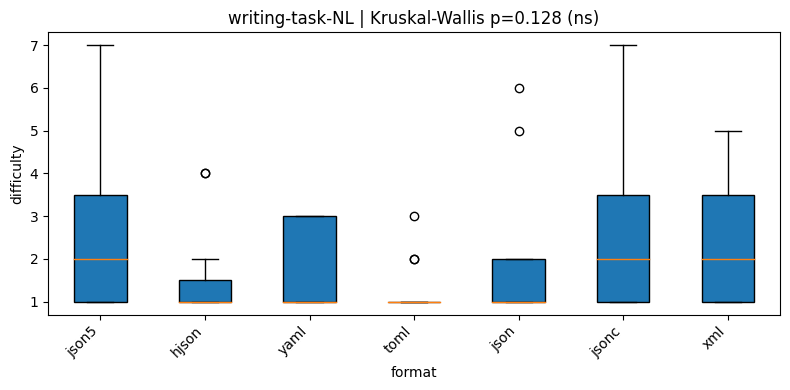

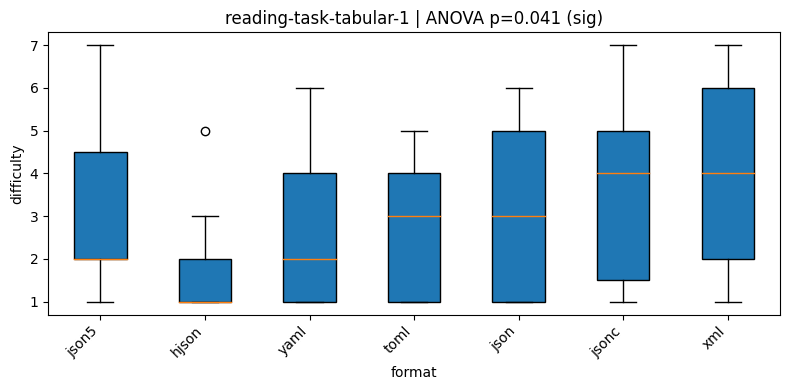

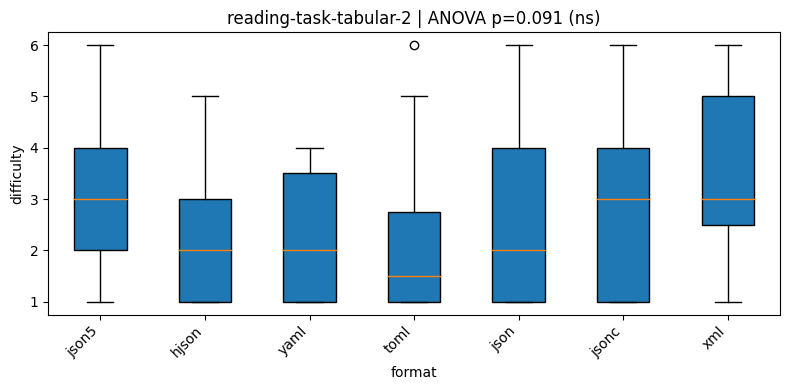

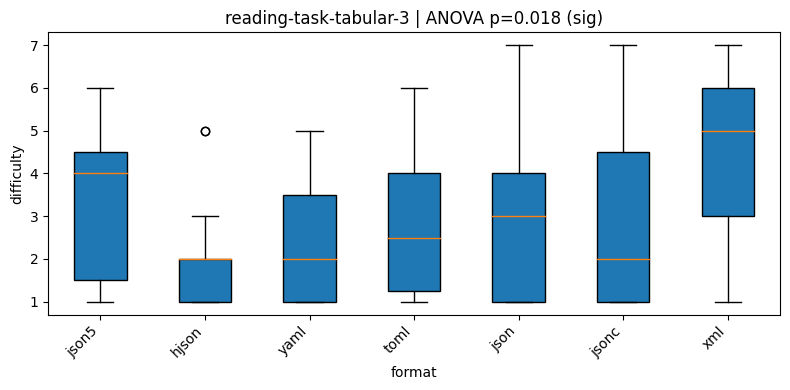

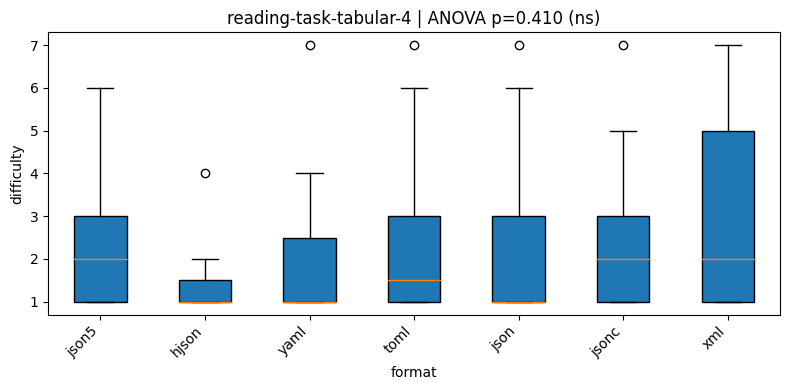

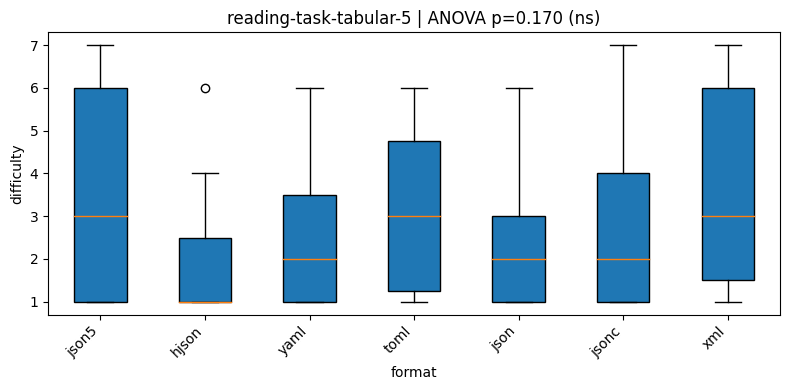

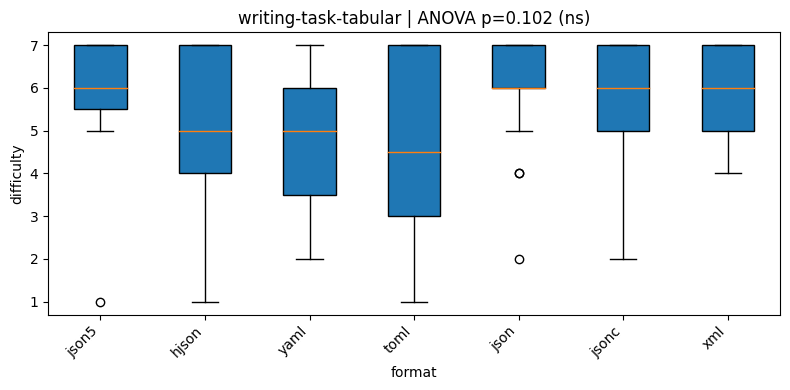

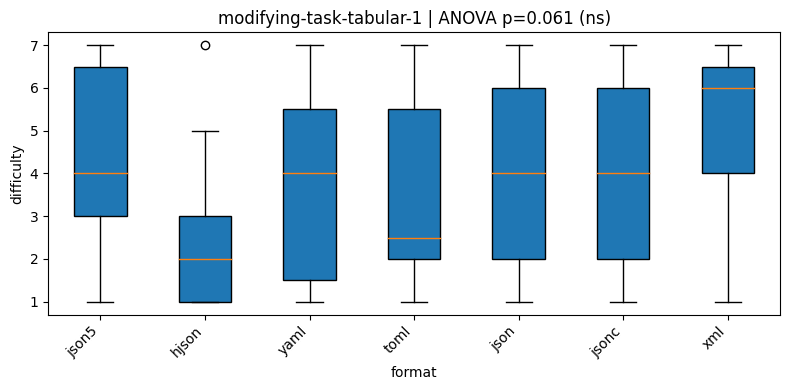

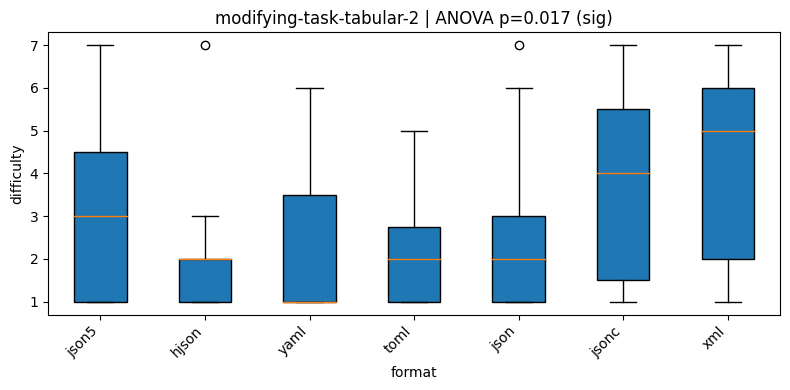

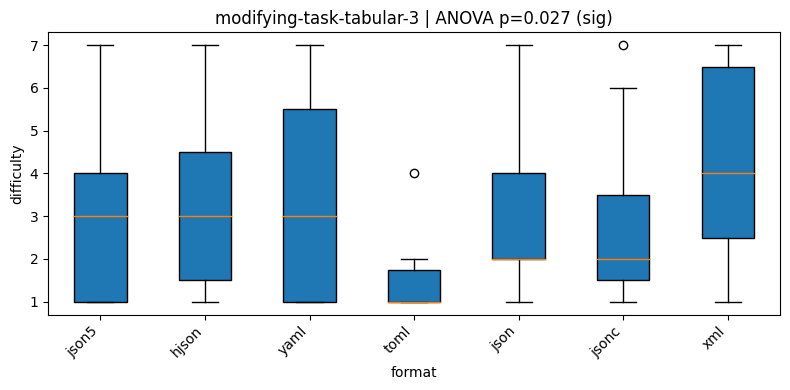

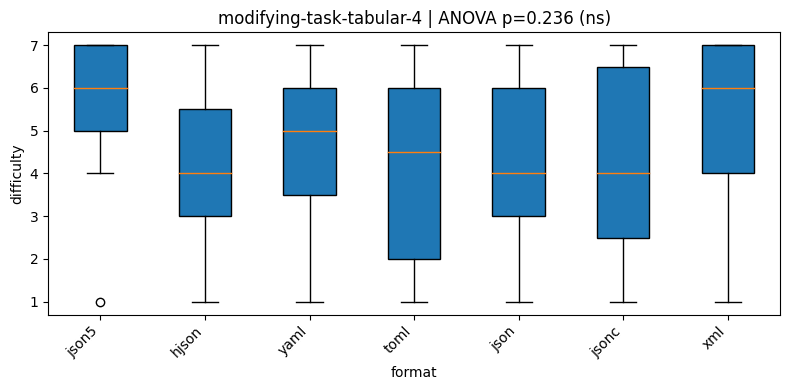

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-NL,0.043270,Kruskal-Wallis,0.128408,False,[]
1,reading-task-tabular-1,0.073300,ANOVA,0.041082,True,[hjson vs xml]
2,reading-task-tabular-2,0.475601,ANOVA,0.091000,False,[]
3,reading-task-tabular-3,0.337408,ANOVA,0.018268,True,"[hjson vs xml, xml vs yaml]"
4,reading-task-tabular-4,0.260737,ANOVA,0.409702,False,[]
5,reading-task-tabular-5,0.054295,ANOVA,0.169552,False,[]
6,writing-task-tabular,0.130812,ANOVA,0.101691,False,[]
7,modifying-task-tabular-1,0.720784,ANOVA,0.061420,False,[]
8,modifying-task-tabular-2,0.186398,ANOVA,0.016799,True,[]
9,modifying-task-tabular-3,0.056521,ANOVA,0.026805,True,[toml vs xml]


In [57]:
summary_post_d = analyze_metric_differences(
    df=df_post_clean,
    task_col='task',
    group_col='format',
    metric_col='difficulty',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_post_d

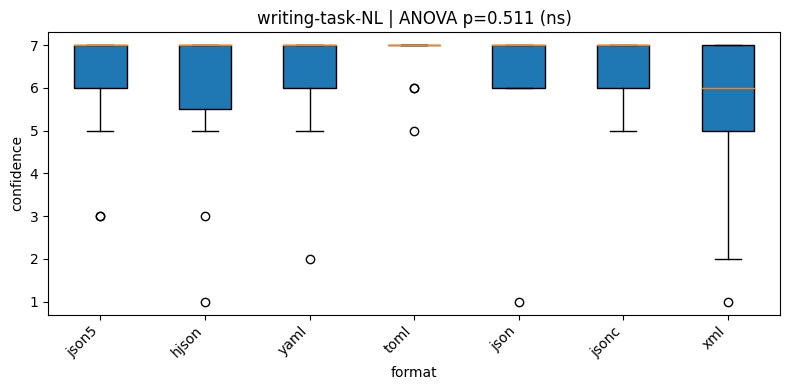

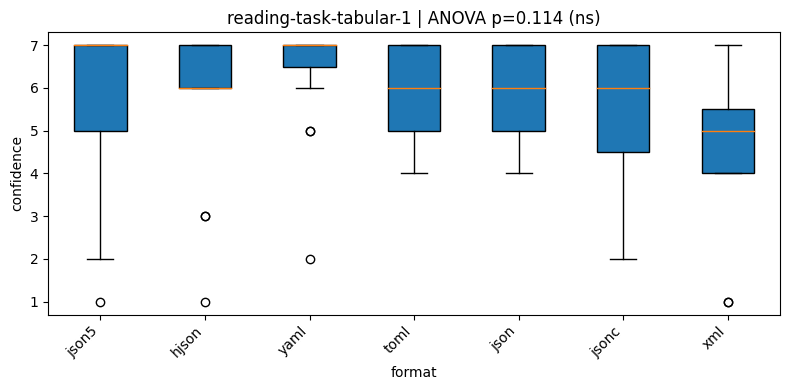

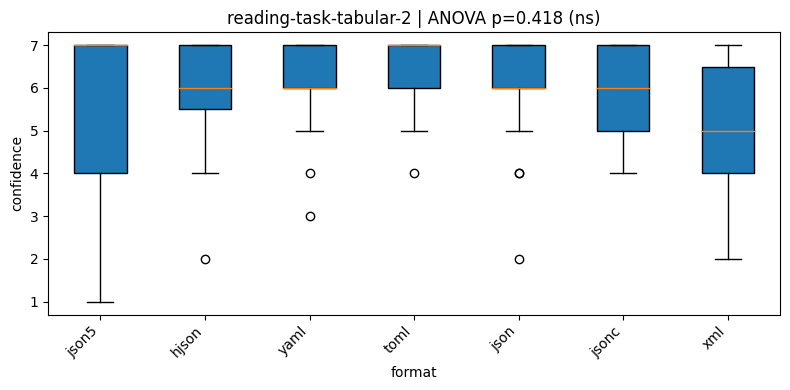

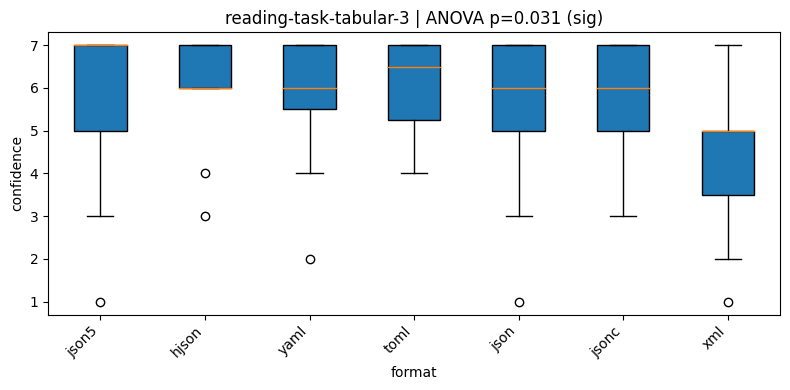

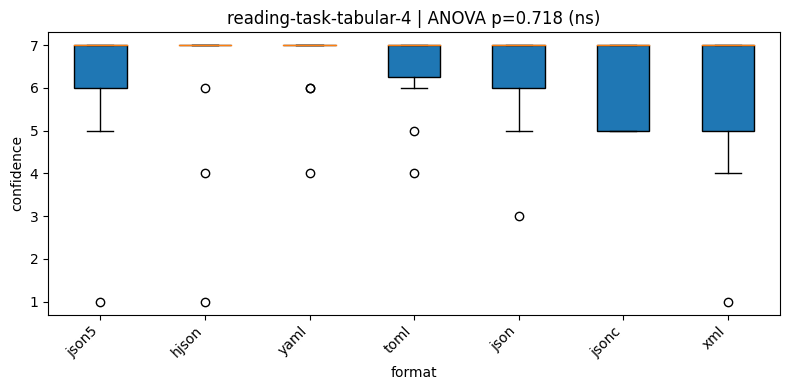

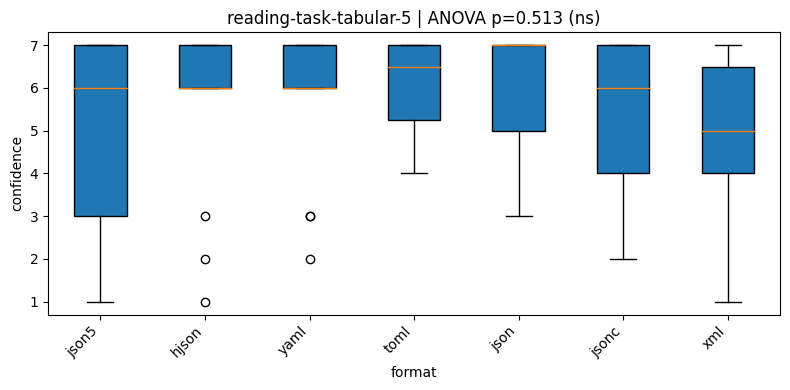

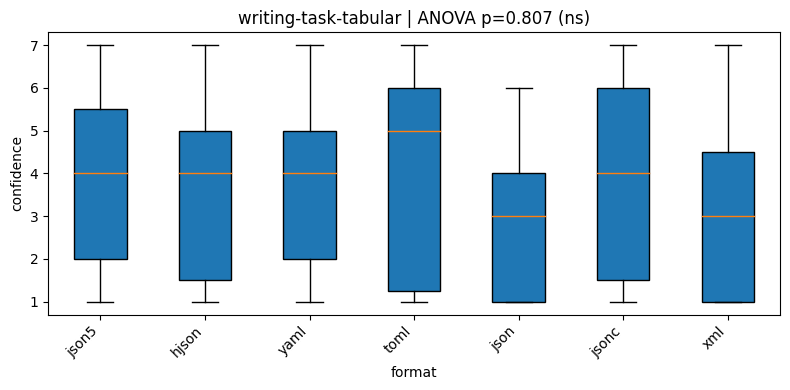

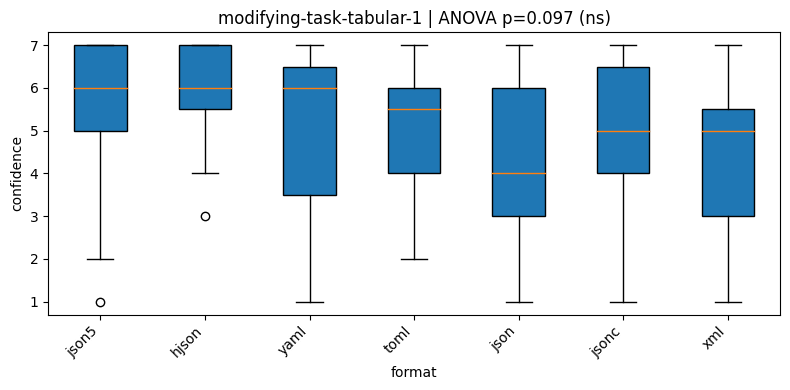

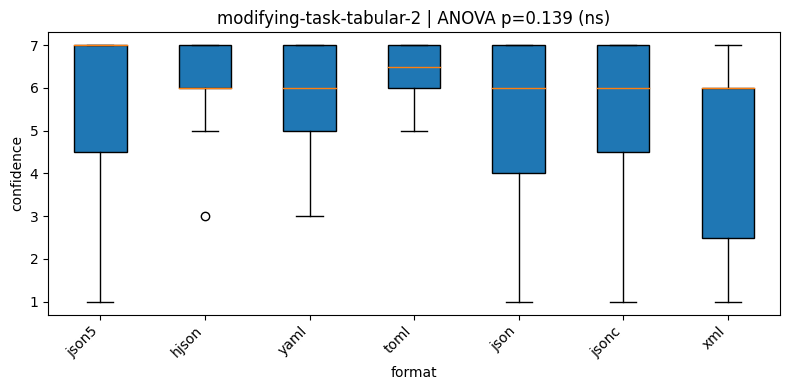

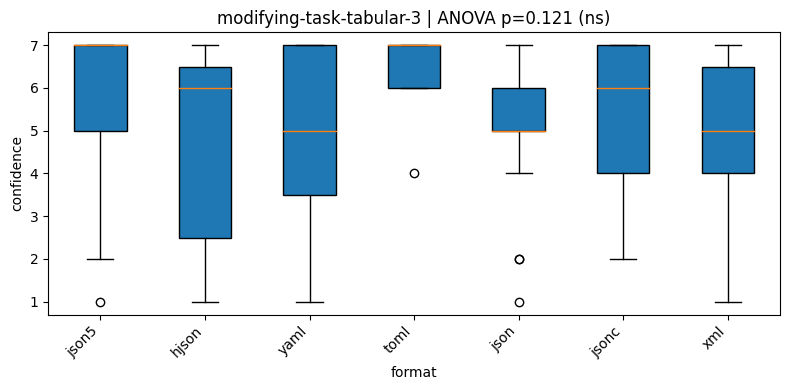

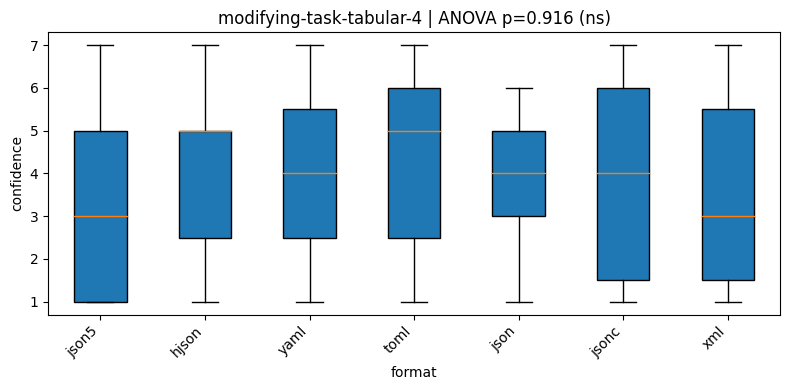

,task,homogeneity_p,test,test_p,significant,posthoc
0,writing-task-NL,0.501931,ANOVA,0.511296,False,[]
1,reading-task-tabular-1,0.771346,ANOVA,0.113917,False,[]
2,reading-task-tabular-2,0.431789,ANOVA,0.418484,False,[]
3,reading-task-tabular-3,0.871909,ANOVA,0.031149,True,"[hjson vs xml, toml vs xml]"
4,reading-task-tabular-4,0.718155,ANOVA,0.718155,False,[]
5,reading-task-tabular-5,0.676954,ANOVA,0.513058,False,[]
6,writing-task-tabular,0.862755,ANOVA,0.807411,False,[]
7,modifying-task-tabular-1,0.750518,ANOVA,0.096819,False,[]
8,modifying-task-tabular-2,0.273966,ANOVA,0.139046,False,[]
9,modifying-task-tabular-3,0.269199,ANOVA,0.121364,False,[]


In [58]:
summary_post_c = analyze_metric_differences(
    df=df_post_clean,
    task_col='task',
    group_col='format',
    metric_col='confidence',
    alpha=0.05,
    clean_suffix=True  # 会把 writing-task-tabular-json5 → writing-task-tabular
)

summary_post_c

## compare

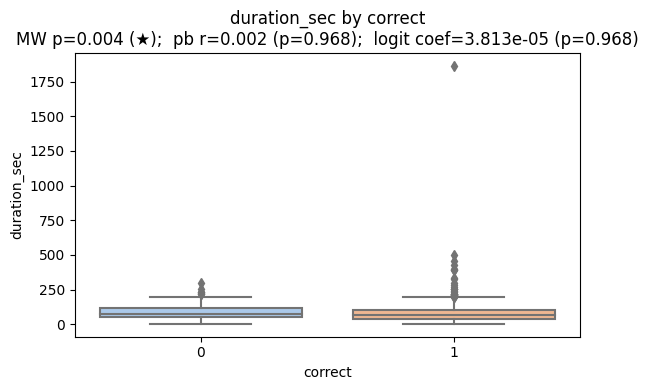

,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,duration_sec,74.007,62.918,33908.0,0.004049,0.001763,0.967705,0.000038,0.967632,Median(time|correct=1) is lower than wrong (62...


In [108]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import mannwhitneyu, pointbiserialr
# import statsmodels.formula.api as smf

# def compare_correctness_timing(
#     df: pd.DataFrame,
#     correct_col: str = 'correct',
#     time_cols:   list = ['duration_sec'],
#     alpha:       float = 0.05,
#     figsize:     tuple = (6,4)
# ) -> pd.DataFrame:
#     """
#     比较 correctness (0/1) 与多个时长指标的关系，
#     并给出易读的检验结果和解读：

#       - 箱线图 + 中位数直观对比
#       - Mann–Whitney U 检验 (非参数)
#       - 点二列相关 (point‐biserial)
#       - Logistic 回归

#     最后返回一张表，每行是一种 time_col，加上 summary 和 interpretation 列。
#     """
#     results = []

#     # 确保正确性列是 0/1
#     df = df.copy()
#     df[correct_col] = pd.to_numeric(df[correct_col], errors='coerce').fillna(0).astype(int)

#     for metric in time_cols:
#         sub = df[[correct_col, metric]].dropna()
#         grp0 = sub.loc[sub[correct_col]==0, metric]
#         grp1 = sub.loc[sub[correct_col]==1, metric]

#         # 画箱线图
#         plt.figure(figsize=figsize)
#         sns.boxplot(x=correct_col, y=metric, data=sub, palette='pastel')
#         plt.title(f"{metric} by {correct_col} (0=wrong, 1=right)")
#         plt.xlabel(correct_col)
#         plt.ylabel(metric)
#         plt.tight_layout()
#         plt.show()

#         # 中位数对比
#         med0, med1 = grp0.median(), grp1.median()
#         direction = 'lower' if med1 < med0 else 'higher'

#         # 1) Mann–Whitney U
#         if len(grp0)>0 and len(grp1)>0:
#             U, p_mwu = mannwhitneyu(grp0, grp1, alternative='two-sided')
#             sig_mwu = p_mwu < alpha
#         else:
#             U, p_mwu, sig_mwu = None, None, False

#         # 2) 点二列相关
#         try:
#             r_pb, p_corr = pointbiserialr(sub[correct_col], sub[metric])
#             sig_corr = p_corr < alpha
#         except:
#             r_pb, p_corr, sig_corr = None, None, False

#         # 3) Logistic 回归
#         try:
#             formula = f"{correct_col} ~ {metric}"
#             logit = smf.logit(formula, data=sub).fit(disp=False)
#             coef   = logit.params[metric]
#             p_log  = logit.pvalues[metric]
#             sig_log = p_log < alpha
#         except:
#             coef, p_log, sig_log = None, None, False

#         # 汇总解读
#         interp = (
#             f"Median(time|correct=1) is {direction} than wrong "
#             f"({med1:.2f} vs {med0:.2f}). "
#             f"Mann–Whitney U={U:.1f}, p={p_mwu:.3f} "
#             f"({'sig' if sig_mwu else 'ns'}). "
#             f"Point‐biserial r={r_pb:.3f}, p={p_corr:.3f} "
#             f"({'sig' if sig_corr else 'ns'}). "
#             f"Logit coef={coef:.3e}, p={p_log:.3f} "
#             f"({'sig' if sig_log else 'ns'})."
#         )

#         results.append({
#             'metric':        metric,
#             'median_wrong':  med0,
#             'median_correct':med1,
#             'U_stat':        U,
#             'p_mwu':         p_mwu,
#             'r_pb':          r_pb,
#             'p_corr':        p_corr,
#             'logit_coef':    coef,
#             'p_logit':       p_log,
#             'interpretation':interp
#         })

#     return pd.DataFrame(results)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pointbiserialr
import statsmodels.formula.api as smf

def compare_correctness_timing(
    df: pd.DataFrame,
    correct_col: str = 'correct',
    time_cols:   list = ['duration_sec'],
    alpha:       float = 0.05,
    figsize:     tuple = (6,4)
) -> pd.DataFrame:
    """
    比较 correctness (0/1) 与多个时长指标的关系，
    并给出易读的检验结果和解读，同时在箱线图标题里
    直接标出各项统计量（p 值和显著性标记）。

    返回值：每行一个 time_col，对应：
      - median_wrong / median_correct
      - U_stat, p_mwu
      - r_pb, p_corr
      - logit_coef, p_logit
      - interpretation（文字解读）
    """
    results = []

    # 1) 保证 correct 列是 0/1
    df2 = df.copy()
    df2[correct_col] = (
        pd.to_numeric(df2[correct_col], errors='coerce')
          .fillna(0)
          .astype(int)
    )

    for metric in time_cols:
        sub = df2[[correct_col, metric]].dropna()
        grp0 = sub.loc[sub[correct_col]==0, metric]
        grp1 = sub.loc[sub[correct_col]==1, metric]

        # 2) 中位数 & Mann–Whitney U
        med0, med1 = grp0.median(), grp1.median()
        direction = 'lower' if med1 < med0 else 'higher'

        if len(grp0) > 0 and len(grp1) > 0:
            U, p_mwu = mannwhitneyu(grp0, grp1, alternative='two-sided')
            sig_mwu = p_mwu < alpha
        else:
            U, p_mwu, sig_mwu = None, None, False

        # 3) 点二列相关
        try:
            r_pb, p_corr = pointbiserialr(sub[correct_col], sub[metric])
            sig_corr = p_corr < alpha
        except:
            r_pb, p_corr, sig_corr = None, None, False

        # 4) Logistic 回归
        try:
            logit = smf.logit(f"{correct_col} ~ {metric}", data=sub).fit(disp=False)
            coef   = logit.params.get(metric, None)
            p_log  = logit.pvalues.get(metric, None)
            sig_log = (p_log is not None and p_log < alpha)
        except:
            coef, p_log, sig_log = None, None, False

        # 5) 画箱线图，并把所有 p 值和 ★/ns 都贴到标题里
        plt.figure(figsize=figsize)
        sns.boxplot(x=correct_col, y=metric, data=sub, palette='pastel')
        title = (
            f"{metric} by {correct_col}\n"
            f"MW p={p_mwu:.3f} ({'★' if sig_mwu else 'ns'});  "
            f"pb r={r_pb:.3f} (p={p_corr:.3f});  "
            f"logit coef={coef:.3e} (p={p_log:.3f})"
        )
        plt.title(title)
        plt.xlabel(correct_col)
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()

        # 6) 文字解读
        interp = (
            f"Median(time|correct=1) is {direction} than wrong "
            f"({med1:.2f} vs {med0:.2f}). "
            f"Mann–Whitney U={U:.1f}, p={p_mwu:.3f} "
            f"({'sig' if sig_mwu else 'ns'}); "
            f"Point‐biserial r={r_pb:.3f}, p={p_corr:.3f} "
            f"({'sig' if sig_corr else 'ns'}); "
            f"Logit coef={coef:.3e}, p={p_log:.3f} "
            f"({'sig' if sig_log else 'ns'})."
        )

        results.append({
            'metric':         metric,
            'median_wrong':   med0,
            'median_correct': med1,
            'U_stat':         U,
            'p_mwu':          p_mwu,
            'r_pb':           r_pb,
            'p_corr':         p_corr,
            'logit_coef':     coef,
            'p_logit':        p_log,
            'interpretation': interp
        })

    return pd.DataFrame(results)

summary = compare_correctness_timing(
    df_result,
    correct_col = 'correct',
    time_cols   = ['duration_sec']
)
summary

In [70]:
for txt in summary['interpretation']:
    print(txt)

Median(time|correct=1) is lower than wrong (62.92 vs 74.01). Mann–Whitney U=33908.0, p=0.004 (sig). Point‐biserial r=0.002, p=0.968 (ns). Logit coef=3.813e-05, p=0.968 (ns).


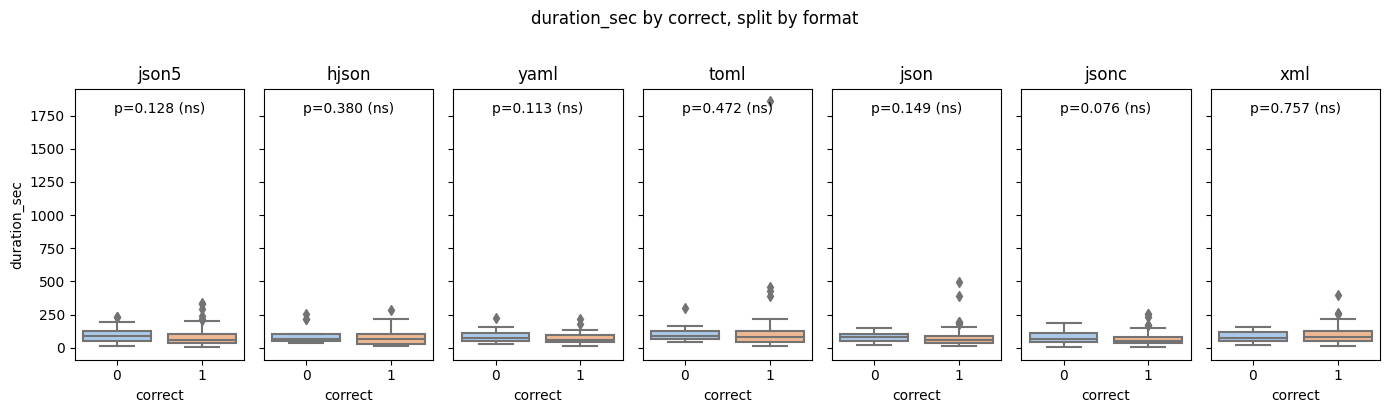

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pointbiserialr
import statsmodels.formula.api as smf

def compare_correctness_timing_by_format(
    df: pd.DataFrame,
    correct_col: str   = 'correct',
    time_cols:   list  = ['duration_sec'],
    format_col:  str   = 'format',
    alpha:       float = 0.05,
    figsize:     tuple = (12, 4)
):
    """
    按 format 做 FacetGrid：
      - 每个 format 一列
      - 箱线图展示 correct=0/1 在 time_cols 上的分布
    并且在每个 Facet 上标出 Mann–Whitney p 值。

    参数
    ----
    df          原始 df，需要有 correct_col, time_cols, format_col
    correct_col 0/1 列
    time_cols   要比较的时长列列表
    format_col  按哪个列分面
    alpha       显著性水平，用来判断 p<alpha
    figsize     (宽,高)，这里高为 Facet 高度

    返回
    ----
    None （直接画图并在标题里标 p 值）
    """
    # 确保 correct 是 0/1
    df = df.copy()
    df[correct_col] = pd.to_numeric(df[correct_col], errors='coerce').fillna(0).astype(int)

    for metric in time_cols:
        # FacetGrid: 每个 format 一列
        formats = df[format_col].unique()
        ncol = len(formats)
        fig, axes = plt.subplots(1, ncol, figsize=(figsize[0], figsize[1]), sharey=True)
        if ncol == 1:
            axes = [axes]

        for ax, fmt in zip(axes, formats):
            sub = df[df[format_col] == fmt]
            sns.boxplot(x=correct_col, y=metric, data=sub, ax=ax, palette='pastel')
            ax.set_title(f"{fmt}")
            ax.set_xlabel("correct")
            ax.set_ylabel(metric if ax is axes[0] else "")
            # 统计检验
            grp0 = sub.loc[sub[correct_col]==0, metric]
            grp1 = sub.loc[sub[correct_col]==1, metric]
            if len(grp0)>0 and len(grp1)>0:
                _, p = mannwhitneyu(grp0, grp1, alternative='two-sided')
                sig = "★" if p<alpha else "ns"
                ax.text(0.5, 0.95, f"p={p:.3f} ({sig})",
                        transform=ax.transAxes,
                        ha='center', va='top',
                        fontsize=10)
        plt.suptitle(f"{metric} by correct, split by {format_col}", y=1.02)
        plt.tight_layout()
        plt.show()

compare_correctness_timing_by_format(
    df          = df_result,
    correct_col = 'correct',
    time_cols   = ['duration_sec'],
    format_col  = 'format',
    alpha       = 0.05,
    figsize     = (14,4)
)

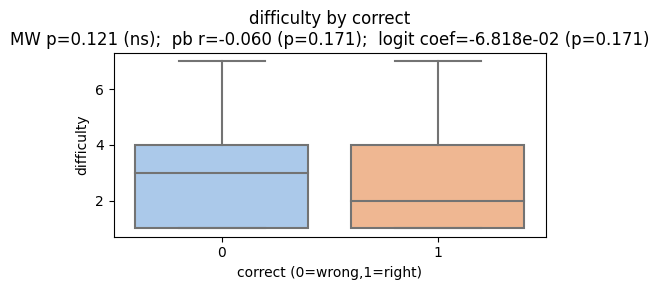

,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,difficulty,3.0,2.0,31695.0,0.121082,-0.05958,0.170809,-0.068181,0.17089,median(difficulty|correct=1) is lower than wro...


In [109]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pointbiserialr
import statsmodels.formula.api as smf

def compare_posttask_correctness(
    df_post:     pd.DataFrame,
    df_correct:  pd.DataFrame,
    tasks:       list,
    metric_col:  str = 'difficulty',
    correct_col: str = 'correct',
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    task_col:        str = 'task',
    alpha:       float = 0.05,
    figsize:     tuple = (6,4)
) -> pd.DataFrame:
    """
    对 post-task 的 difficulty/confidence 与 correctness(0/1) 做对比，
    只保留 task_col 中包含 tasks 列表的行，然后
    1) 箱线图，标题一次性展示 MW U、point-biserial 和 logit 的 p 值及显著★/ns  
    2) 返回汇总表：median_wrong/median_correct + 各检验的统计量 + interpretation
    """
    # —— 1. 过滤 & 合并 correct ——
    pat = "|".join(tasks)
    df_sel = df_post[df_post[task_col].str.contains(pat)].copy()

    dfm = pd.merge(
        df_sel,
        df_correct[[participant_col, format_col, task_col, correct_col]],
        on=[participant_col, format_col, task_col],
        how='inner'
    ).dropna(subset=[metric_col, correct_col])
    dfm[correct_col] = dfm[correct_col].astype(int)

    sub = dfm[[metric_col, correct_col]]

    # —— 2. 分组中位数 & Mann–Whitney U —— 
    grp0 = sub.loc[sub[correct_col]==0, metric_col]
    grp1 = sub.loc[sub[correct_col]==1, metric_col]
    med0, med1 = grp0.median(), grp1.median()
    direction = 'lower' if med1 < med0 else 'higher'

    if len(grp0)>0 and len(grp1)>0:
        U, p_mwu = mannwhitneyu(grp0, grp1, alternative='two-sided')
        sig_mwu = p_mwu < alpha
    else:
        U, p_mwu, sig_mwu = None, None, False

    # —— 3. 点二列相关 —— 
    try:
        r_pb, p_corr = pointbiserialr(sub[correct_col], sub[metric_col])
        sig_corr = p_corr < alpha
    except:
        r_pb, p_corr, sig_corr = None, None, False

    # —— 4. Logistic 回归 —— 
    try:
        logit = smf.logit(f"{correct_col} ~ {metric_col}", data=sub).fit(disp=False)
        coef   = logit.params.get(metric_col, None)
        p_log  = logit.pvalues.get(metric_col, None)
        sig_log = (p_log is not None and p_log < alpha)
    except:
        coef, p_log, sig_log = None, None, False

    # —— 5. 画箱线图 + 在标题一次性标三项检验 —— 
    plt.figure(figsize=figsize)
    sns.boxplot(x=correct_col, y=metric_col, data=sub, palette='pastel')
    title = (
        f"{metric_col} by correct\n"
        f"MW p={p_mwu:.3f} ({'★' if sig_mwu else 'ns'});  "
        f"pb r={r_pb:.3f} (p={p_corr:.3f});  "
        f"logit coef={coef:.3e} (p={p_log:.3f})"
    )
    plt.title(title)
    plt.xlabel('correct (0=wrong,1=right)')
    plt.ylabel(metric_col)
    plt.tight_layout()
    plt.show()

    # —— 6. 文字解读 & 返回表 —— 
    interp = (
        f"median({metric_col}|correct=1) is {direction} than wrong "
        f"({med1:.2f} vs {med0:.2f}). "
        f"MW U={U:.1f}, p={p_mwu:.3f} ({'sig' if sig_mwu else 'ns'}); "
        f"point-biserial r={r_pb:.3f}, p={p_corr:.3f} "
        f"({'sig' if sig_corr else 'ns'}); "
        f"logit coef={coef:.3e}, p={p_log:.3f} "
        f"({'sig' if sig_log else 'ns'})."
    )

    return pd.DataFrame([{
        'metric':         metric_col,
        'median_wrong':   med0,
        'median_correct': med1,
        'U_stat':         U,
        'p_mwu':          p_mwu,
        'r_pb':           r_pb,
        'p_corr':         p_corr,
        'logit_coef':     coef,
        'p_logit':        p_log,
        'interpretation': interp
    }])


# 对 df_result 做清洗
df_result_clean = clean_task_format(
    df_result,
    task_col='task',
    format_col='format'
)

df_result_clean=clean_task_format(df_result, task_col = 'task', format_col = 'format')

# 假设 df_post_clean, df_reading_clean（或 df_quiz_clean） 已就绪
summary = compare_posttask_correctness(
    df_post     = df_post_clean,
    df_correct  = df_result_clean,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'difficulty',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)
summary



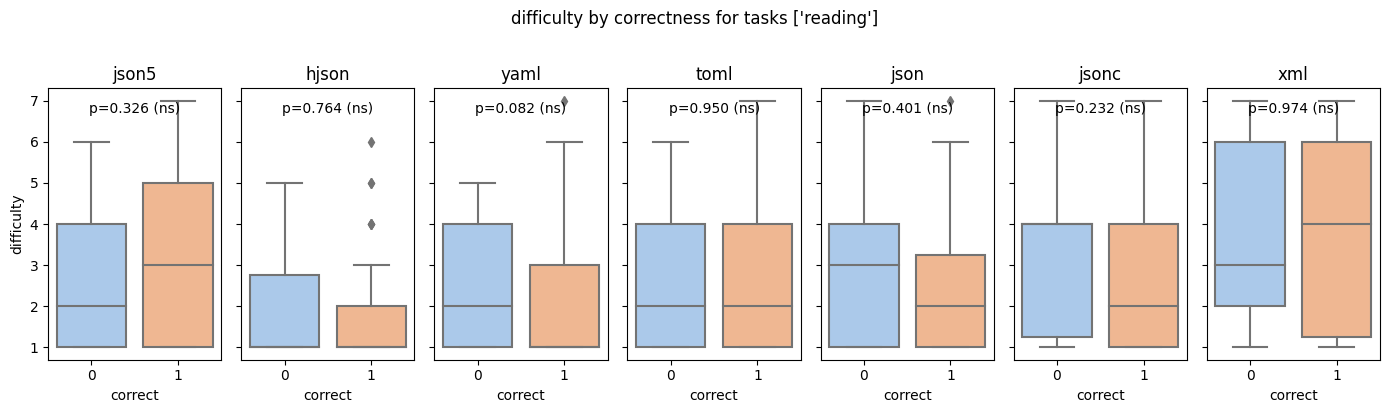

In [105]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pointbiserialr
import statsmodels.formula.api as smf

def compare_posttask_by_format(
    df_post:     pd.DataFrame,
    df_correct:  pd.DataFrame,
    tasks:       list,
    metric_col:  str = 'difficulty',
    correct_col: str = 'correct',
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    task_col:        str = 'task',
    alpha:       float = 0.05,
    figsize:     tuple = (12,4)
):
    """
    对 post-task 的 metric_col vs correct 做 Facet 分面：
      - 只保留 task_col 中包含 tasks 列表的行
      - 每个 format 一子图，箱线展示 correct=0/1 的分布
      - 在子图顶部标出 Mann–Whitney p 值（★ 表示 p<alpha）
    """
    # 1) 过滤 tasks
    pat = "|".join(tasks)
    df_sel = df_post[df_post[task_col].str.contains(pat)].copy()

    # 2) 合并 correct
    dfm = pd.merge(
        df_sel,
        df_correct[[participant_col, format_col, task_col, correct_col]],
        on=[participant_col, format_col, task_col],
        how='inner'
    ).dropna(subset=[metric_col, correct_col])
    dfm[correct_col] = dfm[correct_col].astype(int)

    # 3) 准备分面
    formats = dfm[format_col].unique()
    ncol = len(formats)
    fig, axes = plt.subplots(1, ncol, figsize=(figsize[0], figsize[1]), sharey=True)
    if ncol == 1:
        axes = [axes]

    # 4) 每个 format 画箱线并注 p 值
    for ax, fmt in zip(axes, formats):
        sub = dfm[dfm[format_col] == fmt]
        sns.boxplot(x=correct_col, y=metric_col, data=sub, ax=ax, palette='pastel')
        ax.set_title(fmt)
        ax.set_xlabel('correct')
        ax.set_ylabel(metric_col if ax is axes[0] else '')

        # Mann–Whitney
        g0 = sub.loc[sub[correct_col]==0, metric_col]
        g1 = sub.loc[sub[correct_col]==1, metric_col]
        if len(g0)>0 and len(g1)>0:
            _, p = mannwhitneyu(g0, g1, alternative='two-sided')
            sig = '★' if p<alpha else 'ns'
            ax.text(0.5, 0.95, f"p={p:.3f} ({sig})",
                    transform=ax.transAxes,
                    ha='center', va='top',
                    fontsize=10)
    plt.suptitle(f"{metric_col} by correctness for tasks {tasks}", y=1.02)
    plt.tight_layout()
    plt.show()

compare_posttask_by_format(
    df_post    = df_post_clean,
    df_correct = df_result_clean,
    tasks      = ['reading'],       # 或 ['writing','modifying']
    metric_col = 'difficulty',      # 或 'confidence'
    figsize    = (14,4)
)

In [72]:
for txt in summary['interpretation']:
    print(txt)

For tasks ['reading'], median(difficulty|correct=1) is lower than wrong (2.00 vs 3.00). Mann–Whitney U=31695.0, p=0.121 (ns). Point‐biserial r=-0.060, p=0.171 (ns). Logit coef=-6.818e-02, p=0.171 (ns).


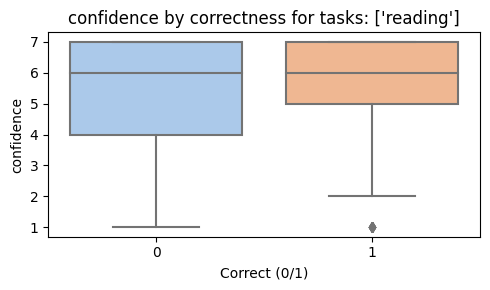

For tasks ['reading'], median(confidence|correct=1) is higher than wrong (6.00 vs 6.00). Mann–Whitney U=26436.5, p=0.059 (ns). Point‐biserial r=0.099, p=0.023 (sig). Logit coef=1.305e-01, p=0.024 (sig).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,confidence,6.0,6.0,26436.5,0.059218,0.098575,0.023236,0.13055,0.024296,"For tasks ['reading'], median(confidence|corre..."


In [73]:
summary = compare_posttask_correctness(
    df_post     = df_post_clean,
    df_correct  = df_result_clean,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'confidence',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)
for txt in summary['interpretation']:
    print(txt)
summary

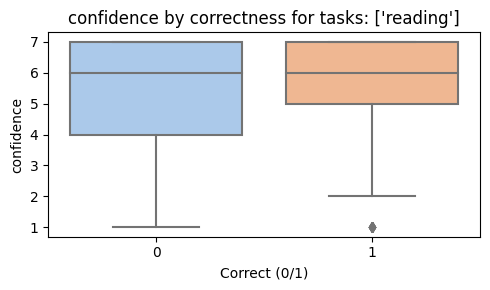

For tasks ['reading'], median(confidence|correct=1) is higher than wrong (6.00 vs 6.00). Mann–Whitney U=26436.5, p=0.059 (ns). Point‐biserial r=0.099, p=0.023 (sig). Logit coef=1.305e-01, p=0.024 (sig).


,metric,median_wrong,median_correct,U_stat,p_mwu,r_pb,p_corr,logit_coef,p_logit,interpretation
0,confidence,6.0,6.0,26436.5,0.059218,0.098575,0.023236,0.13055,0.024296,"For tasks ['reading'], median(confidence|corre..."


In [96]:
summary = compare_posttask_correctness(
    df_post     = df_post_clean,
    df_correct  = df_result_clean,   # or df_writing_clean, df_modifying_clean
    tasks       = ['reading'],        # 只比 reading-task-*
    metric_col  = 'confidence',       # 或 'confidence'
    correct_col = 'correct',
    figsize     = (5,3)
)
for txt in summary['interpretation']:
    print(txt)
summary

In [95]:
# df_nasa

In [94]:
def extract_aggregated_rows(df, task_col='task'):
    """
    Return only the rows whose `task_col` does *not* end in '-<number>'.
    """
    mask = ~df[task_col].str.contains(r'-\d+$', na=False)
    return df[mask].reset_index(drop=True)

df_only_aggregated = extract_aggregated_rows(df_agg)
# df_only_aggregated


In [93]:
# df_quiz_summary

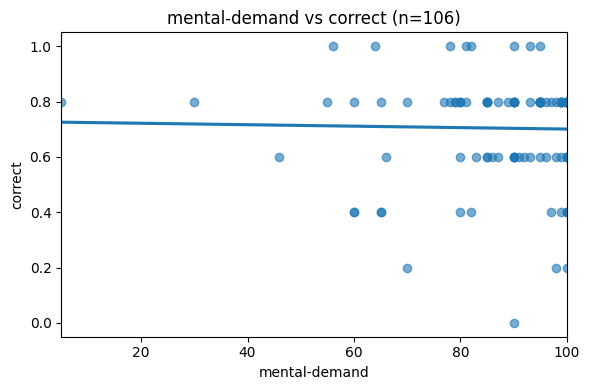

n=106. Pearson r=-0.022 (p=0.824); Spearman rho=-0.058 (p=0.556); Linear slope=N/A (p=N/A).


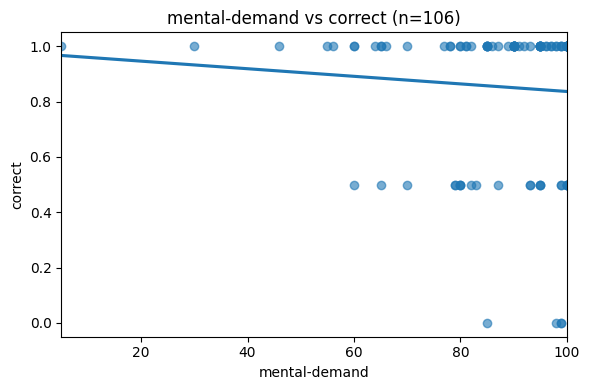

n=106. Pearson r=-0.081 (p=0.408); Spearman rho=-0.010 (p=0.917); Linear slope=N/A (p=N/A).


In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf

def analyze_metric_vs_correct(
    df_metric: pd.DataFrame,
    df_correct: pd.DataFrame,
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    metric_col:      str = 'mental-demand',
    correct_col:     str = 'correct',
    merge_on:        list = None,
    alpha:           float = 0.05,
    figsize:         tuple = (6,4)
) -> pd.DataFrame:
    """
    比较一个连续指标 metric_col 和汇总正确率 correct_col 之间的关系，
    对 None 值做 N/A 处理以免格式化出错。
    """
    if merge_on is None:
        merge_on = [participant_col, format_col]

    # 1) 合并
    df = pd.merge(
        df_metric[[*merge_on, metric_col]],
        df_correct[[*merge_on, correct_col]],
        on=merge_on, how='inner'
    ).dropna(subset=[metric_col, correct_col])

    n = len(df)
    if n == 0:
        raise ValueError("合并后无数据，请检查输入表和 merge_on。")

    # 2) 散点图 + 回归线
    plt.figure(figsize=figsize)
    sns.regplot(x=metric_col, y=correct_col, data=df, ci=None, scatter_kws={'alpha':0.6})
    plt.xlabel(metric_col)
    plt.ylabel(correct_col)
    plt.title(f"{metric_col} vs {correct_col} (n={n})")
    plt.tight_layout()
    plt.show()

    x = df[metric_col].astype(float)
    y = df[correct_col].astype(float)

    # 3) Pearson
    try:
        pearson_r, p_pearson = pearsonr(x, y)
    except Exception:
        pearson_r, p_pearson = None, None

    # 4) Spearman
    try:
        spearman_r, p_spearman = spearmanr(x, y)
    except Exception:
        spearman_r, p_spearman = None, None

    # 5) 线性回归
    try:
        formula = f"{correct_col} ~ {metric_col}"
        fit = smf.ols(formula, data=df).fit()
        slope     = fit.params.get(metric_col, None)
        intercept = fit.params.get("Intercept", None)
        p_slope   = fit.pvalues.get(metric_col, None)
    except Exception:
        slope, intercept, p_slope = None, None, None

    # 6) 防 None 格式化
    def fmt(val, fmt_spec):
        return format(val, fmt_spec) if val is not None else "N/A"

    r1 = fmt(pearson_r, ".3f")
    p1 = fmt(p_pearson, ".3f")
    r2 = fmt(spearman_r, ".3f")
    p2 = fmt(p_spearman, ".3f")
    sl = fmt(slope, ".3e")
    p3 = fmt(p_slope, ".3f")

    interp = (
        f"n={n}. "
        f"Pearson r={r1} (p={p1}); "
        f"Spearman rho={r2} (p={p2}); "
        f"Linear slope={sl} (p={p3})."
    )

    return pd.DataFrame([{
        'n':                n,
        'pearson_r':        pearson_r,
        'p_pearson':        p_pearson,
        'spearman_r':       spearman_r,
        'p_spearman':       p_spearman,
        'linreg_slope':     slope,
        'linreg_intercept': intercept,
        'p_slope':          p_slope,
        'interpretation':   interp
    }])



# 对 mental-demand vs reading-task correct
res1 = analyze_metric_vs_correct(
    df_metric  = df_nasa,
    df_correct = df_only_aggregated,
    metric_col = 'mental-demand',
    correct_col= 'correct'
)
print(res1['interpretation'].iloc[0])

# 对 mental-demand vs tutorial quiz correct
res2 = analyze_metric_vs_correct(
    df_metric  = df_nasa,
    df_correct = df_quiz_summary,
    metric_col = 'mental-demand',
    correct_col= 'correct'
)
print(res2['interpretation'].iloc[0])


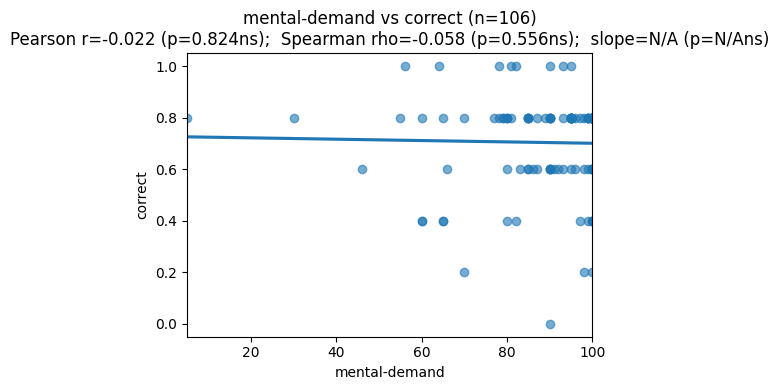

n=106. Pearson r=-0.022 (p=0.824ns); Spearman rho=-0.058 (p=0.556ns); Linear slope=N/A (p=N/Ans).


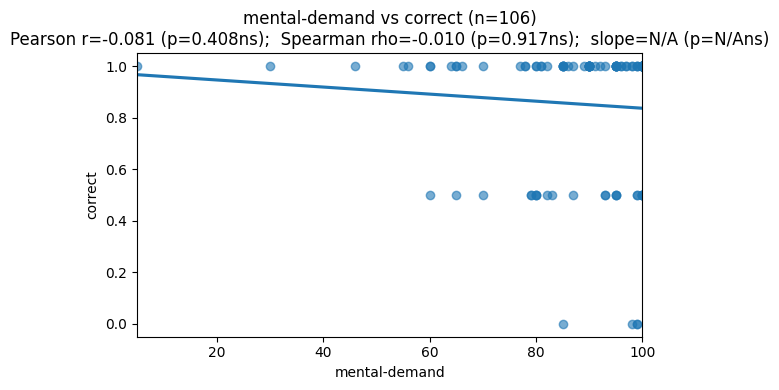

n=106. Pearson r=-0.081 (p=0.408ns); Spearman rho=-0.010 (p=0.917ns); Linear slope=N/A (p=N/Ans).


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf

def analyze_metric_vs_correct(
    df_metric: pd.DataFrame,
    df_correct: pd.DataFrame,
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    metric_col:      str = 'mental-demand',
    correct_col:     str = 'correct',
    merge_on:        list = None,
    alpha:           float = 0.05,
    figsize:         tuple = (6,4)
) -> pd.DataFrame:
    """
    比较连续指标 metric_col 与正确率 correct_col 的关系，
    安全处理 None，标题一次性展示 Pearson/Spearman/OLS 三项检验结果，
    返回带 interpretation 的单行 DataFrame。
    """
    if merge_on is None:
        merge_on = [participant_col, format_col]

    # 1) 合并 & dropna
    df = (
        pd.merge(
            df_metric[[*merge_on, metric_col]],
            df_correct[[*merge_on, correct_col]],
            on=merge_on, how='inner'
        )
        .dropna(subset=[metric_col, correct_col])
    )
    n = len(df)
    if n == 0:
        raise ValueError("合并后无数据，请检查输入表和 merge_on。")

    x = df[metric_col].astype(float)
    y = df[correct_col].astype(float)

    # 2) 统计检验
    try:
        pearson_r, p_pearson = pearsonr(x, y)
    except:
        pearson_r, p_pearson = None, None
    try:
        spearman_r, p_spearman = spearmanr(x, y)
    except:
        spearman_r, p_spearman = None, None
    try:
        formula = f"{correct_col} ~ {metric_col}"
        fit = smf.ols(formula, data=df).fit()
        slope     = fit.params.get(metric_col, None)
        intercept = fit.params.get("Intercept", None)
        p_slope   = fit.pvalues.get(metric_col, None)
    except:
        slope, intercept, p_slope = None, None, None

    # 3) 安全格式化函数
    def fmt(val, spec):
        return f"{val:{spec}}" if val is not None else "N/A"
    # 格式化结果
    r1 = fmt(pearson_r, ".3f"); p1 = fmt(p_pearson, ".3f")
    r2 = fmt(spearman_r, ".3f"); p2 = fmt(p_spearman, ".3f")
    sl = fmt(slope,   ".3e");   p3 = fmt(p_slope,   ".3f")
    # 判断显著 ★/ns
    star1 = '★' if (p_pearson is not None and p_pearson < alpha) else 'ns'
    star2 = '★' if (p_spearman is not None and p_spearman < alpha) else 'ns'
    star3 = '★' if (p_slope   is not None and p_slope   < alpha) else 'ns'

    # 4) 绘图
    plt.figure(figsize=figsize)
    sns.regplot(x=metric_col, y=correct_col, data=df, ci=None, scatter_kws={'alpha':0.6})
    title = (
        f"{metric_col} vs {correct_col} (n={n})\n"
        f"Pearson r={r1} (p={p1}{star1});  "
        f"Spearman rho={r2} (p={p2}{star2});  "
        f"slope={sl} (p={p3}{star3})"
    )
    plt.title(title)
    plt.xlabel(metric_col)
    plt.ylabel(correct_col)
    plt.tight_layout()
    plt.show()

    # 5) 文字解读
    interp = (
        f"n={n}. "
        f"Pearson r={r1} (p={p1}{star1}); "
        f"Spearman rho={r2} (p={p2}{star2}); "
        f"Linear slope={sl} (p={p3}{star3})."
    )

    return pd.DataFrame([{
        'n':                n,
        'pearson_r':        pearson_r,
        'p_pearson':        p_pearson,
        'spearman_r':       spearman_r,
        'p_spearman':       p_spearman,
        'linreg_slope':     slope,
        'linreg_intercept': intercept,
        'p_slope':          p_slope,
        'interpretation':   interp
    }])

# 用法示例：
res1 = analyze_metric_vs_correct(
    df_metric  = df_nasa,
    df_correct = df_only_aggregated,
    metric_col = 'mental-demand',
    correct_col= 'correct',
    merge_on   = ['participantId','format'],
    alpha      = 0.05,
    figsize    = (5,4)
)
print(res1['interpretation'].iloc[0])

res2 = analyze_metric_vs_correct(
    df_metric  = df_nasa,
    df_correct = df_quiz_summary,
    metric_col = 'mental-demand',
    correct_col= 'correct'
)
print(res2['interpretation'].iloc[0])


In [115]:
def summarize_and_plot_by_format(
    df_metric:       pd.DataFrame,
    df_correct:      pd.DataFrame,
    metric_col:      str = 'mental-demand',
    correct_col:     str = 'correct',
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    merge_on:        list = None,
    alpha:           float = 0.05,
    figsize:         tuple = (8,6)
) -> pd.DataFrame:
    """
    1) 合并 df_metric 和 df_correct；
    2) 计算每个 format 的 Mann–Whitney U, point-biserial, logit stats；
    3) 在一张图里画出所有 format 的 scatter + regline，
       并在右侧依次标注每个 format 的 p_mwu 安全格式。
    返回 summary_by_format：每行一个 format，包括统计量和 interpretation。
    """
    if merge_on is None:
        merge_on = [participant_col, format_col]

    # 合并并 drop NA
    df = pd.merge(
            df_metric[[*merge_on, metric_col]],
            df_correct[[*merge_on, correct_col]],
            on=merge_on, how='inner'
        ).dropna(subset=[metric_col, correct_col])
    df[correct_col] = df[correct_col].astype(int)

    formats = df[format_col].unique().tolist()
    palette = sns.color_palette(n_colors=len(formats))

    # 先绘图
    fig, ax = plt.subplots(figsize=figsize)
    for fmt, color in zip(formats, palette):
        sub = df[df[format_col] == fmt]
        ax.scatter(sub[metric_col], sub[correct_col], alpha=0.6, label=fmt, color=color)
        sns.regplot(x=metric_col, y=correct_col, data=sub, scatter=False, ax=ax, color=color)

    ax.set_xlabel(metric_col)
    ax.set_ylabel(f"P({correct_col}=1)")
    ax.set_title(f"{metric_col} vs {correct_col} by format")
    plt.tight_layout()

    # 计算 summary stats
    rows = []
    for fmt in formats:
        sub = df[df[format_col] == fmt]
        wrong = sub[sub[correct_col]==0][metric_col]
        right = sub[sub[correct_col]==1][metric_col]

        # MW
        if len(wrong)>0 and len(right)>0:
            U, p_mwu = mannwhitneyu(wrong, right, alternative='two-sided')
        else:
            U, p_mwu = None, None

        # point-biserial
        try:
            r_pb, p_pb = pointbiserialr(sub[correct_col], sub[metric_col])
        except:
            r_pb, p_pb = None, None

        # logistic
        try:
            m = smf.logit(f"{correct_col} ~ {metric_col}", data=sub).fit(disp=False)
            coef, p_log = m.params[metric_col], m.pvalues[metric_col]
        except:
            coef, p_log = None, None

        # safe formatting
        def fmt(val, spec):
            return format(val, spec) if val is not None else "N/A"

        p_mwu_str = fmt(p_mwu, ".3f")
        star = "★" if (p_mwu is not None and p_mwu < alpha) else "ns"

        interp = (
            f"[{fmt}] MW p={p_mwu_str} ({star}); "
            f"pb r={fmt(r_pb,'.3f')} (p={fmt(p_pb,'.3f')}); "
            f"logit coef={fmt(coef,'.3e')} (p={fmt(p_log,'.3f')})"
        )

        rows.append({
            format_col:  fmt,
            'U_stat':    U,
            'p_mwu':     p_mwu,
            'r_pb':      r_pb,
            'p_pb':      p_pb,
            'logit_coef':coef,
            'p_logit':   p_log,
            'interpretation': interp
        })

    # annotate p_mwu on right side
    y_pos = 0.9
    for fmt, color in zip(formats, palette):
        p_mwu = next((r['p_mwu'] for r in rows if r[format_col]==fmt), None)
        p_str = format(p_mwu, ".3f") if p_mwu is not None else "N/A"
        star = "★" if (p_mwu is not None and p_mwu<alpha) else "ns"
        ax.text(1.05, y_pos, f"{fmt}: p={p_str} ({star})", transform=ax.transAxes, color=color)
        y_pos -= 0.1

    ax.legend(loc='lower right')
    plt.show()

    return pd.DataFrame(rows)


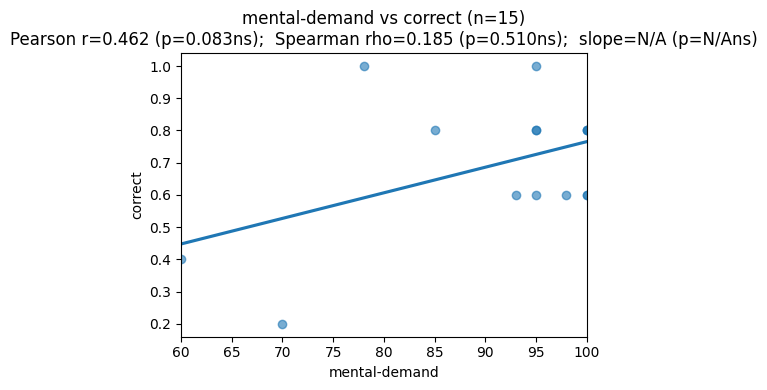

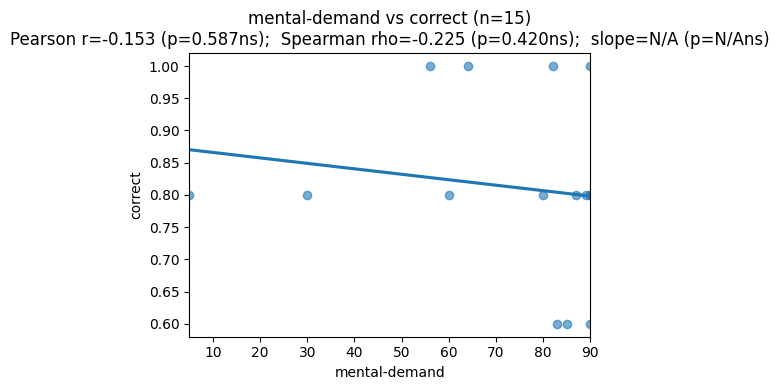

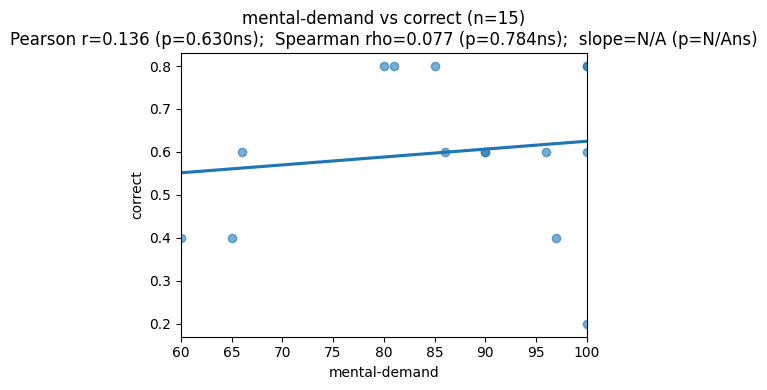

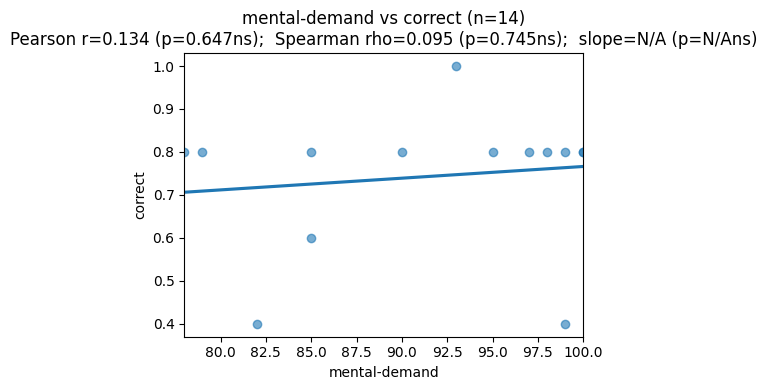

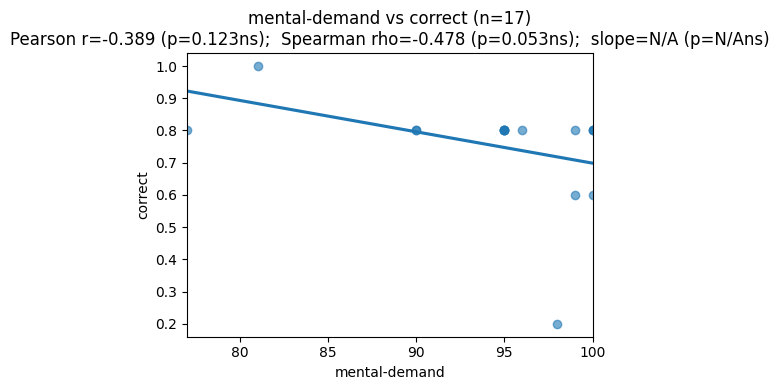

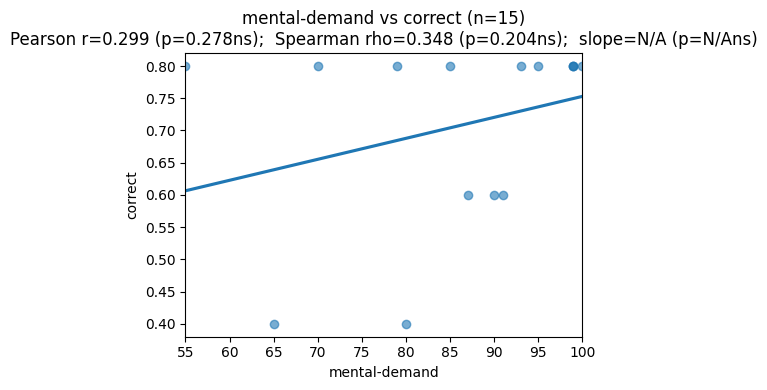

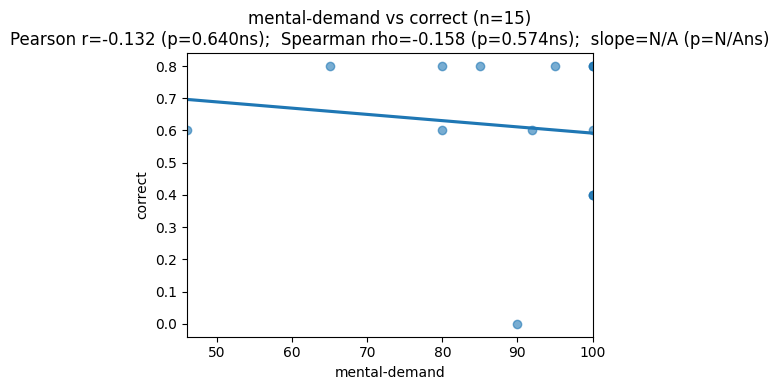

  format                                     interpretation
0  json5  n=15. Pearson r=0.462 (p=0.083ns); Spearman rh...
1  hjson  n=15. Pearson r=-0.153 (p=0.587ns); Spearman r...
2   yaml  n=15. Pearson r=0.136 (p=0.630ns); Spearman rh...
3   toml  n=14. Pearson r=0.134 (p=0.647ns); Spearman rh...
4   json  n=17. Pearson r=-0.389 (p=0.123ns); Spearman r...
5  jsonc  n=15. Pearson r=0.299 (p=0.278ns); Spearman rh...
6    xml  n=15. Pearson r=-0.132 (p=0.640ns); Spearman r...


In [122]:
formats = df_nasa['format'].unique()
all_summaries = []

for fmt in formats:
    # 只挑出这个 format 下的 rows
    df_met = df_nasa   [df_nasa  ['format']==fmt]
    df_cor = df_only_aggregated[df_only_aggregated['format']==fmt]
    
    # 调用已写好的分析函数
    res = analyze_metric_vs_correct(
        df_metric  = df_met,
        df_correct = df_cor,
        metric_col = 'mental-demand',
        correct_col= 'correct',
        merge_on   = ['participantId','format'],
        figsize    = (5,4)
    )
    res['format'] = fmt
    all_summaries.append(res)

summary_by_format = pd.concat(all_summaries, ignore_index=True)
print(summary_by_format[['format','interpretation']])


In [117]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pointbiserialr
import statsmodels.formula.api as smf

def compare_posttask_by_format(
    df_post:      pd.DataFrame,
    df_correct:   pd.DataFrame,
    tasks:        list,
    metric_col:   str = 'difficulty',
    correct_col:  str = 'correct',
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    task_col:        str = 'task',
    alpha:        float = 0.05,
    figsize_per:  tuple = (3,4)
) -> pd.DataFrame:
    """
    按 format 分面、比较 post-task 难度/信心 vs 正确性：
     - 每个 format 一列 subplot
     - 箱线图 + Mann–Whitney p-value（★ 表示 p<alpha）
     - 同时返回各 format 上的检验结果汇总 DataFrame
    """
    # 1) 选出想要的子集 & 合并正确率
    mask = df_post[task_col].str.contains("|".join(tasks))
    df_sel = df_post[mask].copy()
    df_merge = (
        pd.merge(df_sel,
                 df_correct[[participant_col, format_col, task_col, correct_col]],
                 on=[participant_col, format_col, task_col],
                 how='inner')
          .dropna(subset=[metric_col, correct_col])
    )
    df_merge[correct_col] = df_merge[correct_col].astype(int)

    # 2) 统计每个 format 上的 Mann–Whitney p
    formats = sorted(df_merge[format_col].unique())
    summary_rows = []
    for fmt in formats:
        sub = df_merge[df_merge[format_col] == fmt]
        grp0 = sub.loc[sub[correct_col]==0, metric_col]
        grp1 = sub.loc[sub[correct_col]==1, metric_col]
        if len(grp0)>0 and len(grp1)>0:
            U, p_mwu = mannwhitneyu(grp0, grp1, alternative='two-sided')
            sig = p_mwu < alpha
        else:
            U, p_mwu, sig = None, None, False
        summary_rows.append({
            format_col: fmt,
            'U_stat':    U,
            'p_mwu':     p_mwu,
            'sig':       sig
        })
    summary = pd.DataFrame(summary_rows)

    # 3) 绘图：每个 format 一列
    n = len(formats)
    fig, axes = plt.subplots(1, n, figsize=(figsize_per[0]*n, figsize_per[1]), sharey=True)
    if n==1: axes = [axes]

    for ax, fmt in zip(axes, formats):
        sub = df_merge[df_merge[format_col]==fmt]
        sns.boxplot(x=correct_col, y=metric_col, data=sub,
                    palette='pastel', ax=ax)
        ax.set_title(fmt, fontsize=12)
        ax.set_xlabel('')   # 最底下再统一加
        ax.set_xticks([0,1])
        ax.set_xticklabels(['wrong','right'])
        # 标 p 值
        row = summary[summary[format_col]==fmt].iloc[0]
        p = row['p_mwu']
        star = '★' if row['sig'] else 'ns'
        txt = f"p={p:.3f} ({star})" if p is not None else "n/a"
        ax.text(0.5, 0.95, txt,
                ha='center', va='top', transform=ax.transAxes,
                fontsize=10)

    # 4) 整体美化
    axes[0].set_ylabel(metric_col)
    for ax in axes[1:]:
        ax.set_ylabel('')
    fig.suptitle(f"{metric_col} by correctness for tasks {tasks}", y=1.02)
    plt.tight_layout()
    plt.show()

    return summary


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


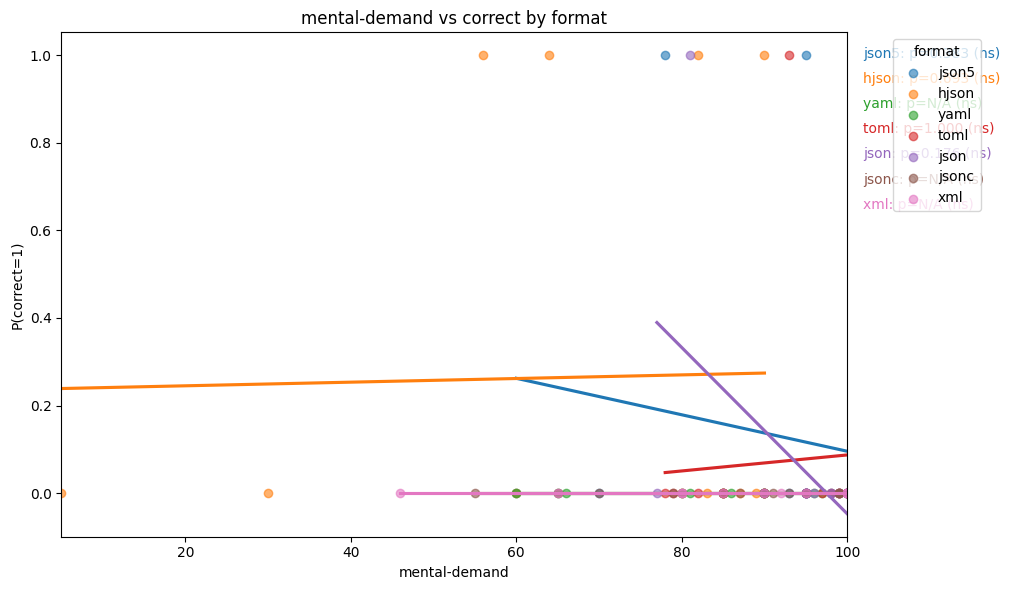

  format                                     interpretation
0  json5  [json5] MW p=0.383 (ns); pb r=-0.146 (p=0.604)...
1  hjson  [hjson] MW p=0.693 (ns); pb r=0.023 (p=0.935);...
2   yaml  [yaml] MW p=N/A (ns); pb r=nan (p=nan); logit ...
3   toml  [toml] MW p=1.000 (ns); pb r=0.056 (p=0.850); ...
4   json  [json] MW p=0.176 (ns); pb r=-0.520 (p=0.032);...
5  jsonc  [jsonc] MW p=N/A (ns); pb r=nan (p=nan); logit...
6    xml  [xml] MW p=N/A (ns); pb r=nan (p=nan); logit c...


In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pointbiserialr
import statsmodels.formula.api as smf

def summarize_and_plot_by_format(
    df_metric:       pd.DataFrame,
    df_correct:      pd.DataFrame,
    metric_col:      str = 'mental-demand',
    correct_col:     str = 'correct',
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    merge_on:        list = None,
    alpha:           float = 0.05,
    figsize:         tuple = (8,6)
) -> pd.DataFrame:
    """
    1) 合并 df_metric 和 df_correct；
    2) 计算每个 format 的 Mann–Whitney U, point-biserial, logit stats；
    3) 在一张图里画出所有 format 的 scatter + regline，
       并在右侧依次标注每个 format 的 p_mwu；
    返回 summary_by_format：每行一个 format，包括统计量和 interpretation。
    """
    if merge_on is None:
        merge_on = [participant_col, format_col]

    # —— 1. 提前检查 correct_col 是否存在 —— #
    if correct_col not in df_correct.columns:
        raise ValueError(
            f"参数 df_correct 中没有列 `{correct_col}`，"
            "请确认你把包含“correct”列的 DataFrame 传给了这个参数。"
        )

    # —— 2. 合并并丢弃 NA —— #
    df = (
        pd.merge(
            df_metric[[*merge_on, metric_col]],
            df_correct[[*merge_on, correct_col]],
            on=merge_on, how='inner'
        )
        .dropna(subset=[metric_col, correct_col])
    )
    df[correct_col] = pd.to_numeric(df[correct_col], errors='coerce').fillna(0).astype(int)

    # —— 3. 可视化—— #
    formats = df[format_col].unique().tolist()
    palette = sns.color_palette("tab10", n_colors=len(formats))

    fig, ax = plt.subplots(figsize=figsize)
    for fmt, color in zip(formats, palette):
        sub = df[df[format_col] == fmt]
        ax.scatter(sub[metric_col], sub[correct_col], alpha=0.6, label=fmt, color=color)
        sns.regplot(
            x=metric_col, y=correct_col, data=sub,
            ci=None, scatter=False, ax=ax, color=color
        )

    ax.set_xlabel(metric_col)
    ax.set_ylabel(f"P({correct_col}=1)")
    ax.set_title(f"{metric_col} vs {correct_col} by format")
    ax.legend(title=format_col, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()

    # —— 4. 汇总统计量 —— #
    def safe_fmt(v, spec):
        return format(v, spec) if v is not None else "N/A"

    rows = []
    for fmt in formats:
        sub = df[df[format_col] == fmt]
        wrong = sub[sub[correct_col] == 0][metric_col]
        right = sub[sub[correct_col] == 1][metric_col]

        # Mann–Whitney U
        if len(wrong)>0 and len(right)>0:
            U, p_mwu = mannwhitneyu(wrong, right, alternative='two-sided')
        else:
            U, p_mwu = None, None

        # Point‐biserial
        try:
            r_pb, p_pb = pointbiserialr(sub[correct_col], sub[metric_col])
        except:
            r_pb, p_pb = None, None

        # Logistic
        try:
            m = smf.logit(f"{correct_col} ~ {metric_col}", data=sub).fit(disp=False)
            coef, p_log = m.params[metric_col], m.pvalues[metric_col]
        except:
            coef, p_log = None, None

        # 生成 interpretation
        p_mwu_s  = safe_fmt(p_mwu, ".3f")
        star     = "★" if (p_mwu is not None and p_mwu < alpha) else "ns"
        interp = (
            f"[{fmt}] MW p={p_mwu_s} ({star}); "
            f"pb r={safe_fmt(r_pb, '.3f')} (p={safe_fmt(p_pb, '.3f')}); "
            f"logit coef={safe_fmt(coef, '.3e')} (p={safe_fmt(p_log, '.3f')})"
        )

        rows.append({
            format_col:      fmt,
            'U_stat':        U,
            'p_mwu':         p_mwu,
            'r_pb':          r_pb,
            'p_pb':          p_pb,
            'logit_coef':    coef,
            'p_logit':       p_log,
            'interpretation': interp
        })

    # —— 5. 在图右侧注 p_mwu —— #
    y0 = 0.95
    dy = 0.05
    for fmt, color in zip(formats, palette):
        rec = next(r for r in rows if r[format_col] == fmt)
        p_s = safe_fmt(rec['p_mwu'], ".3f")
        star = "★" if (rec['p_mwu'] is not None and rec['p_mwu']<alpha) else "ns"
        ax.text(
            1.02, y0,
            f"{fmt}: p={p_s} ({star})",
            transform=ax.transAxes,
            color=color
        )
        y0 -= dy

    plt.show()
    return pd.DataFrame(rows)

# 假设 df_nasa, df_only_aggregated 已准备好，并且 df_only_aggregated 中包含了 'correct' 列
summary_by_format = summarize_and_plot_by_format(
    df_metric  = df_nasa,
    df_correct = df_only_aggregated,
    metric_col = 'mental-demand',
    correct_col= 'correct',
    merge_on   = ['participantId','format'],
    figsize    = (10,6)
)

print(summary_by_format[['format','interpretation']])



## here

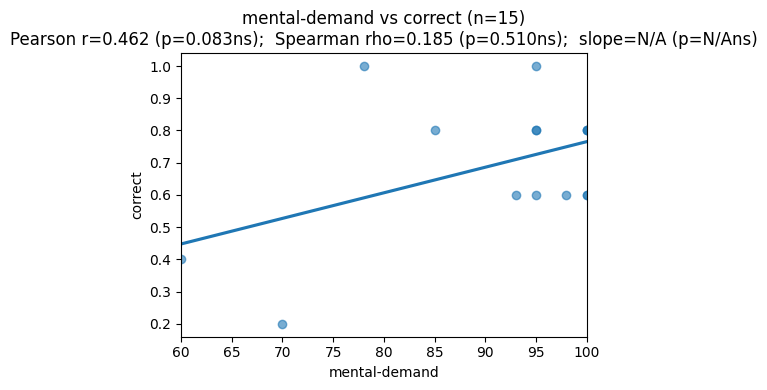

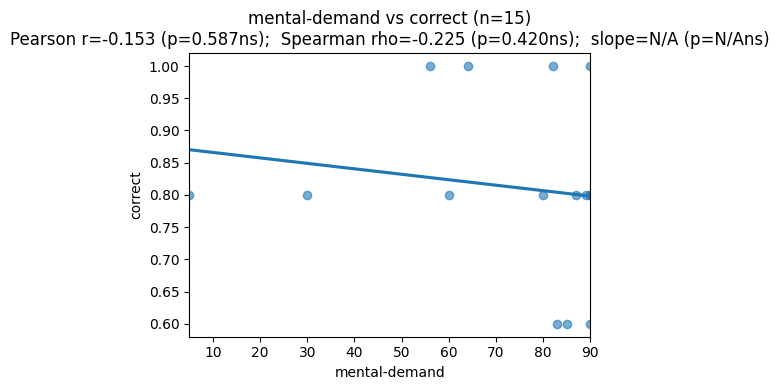

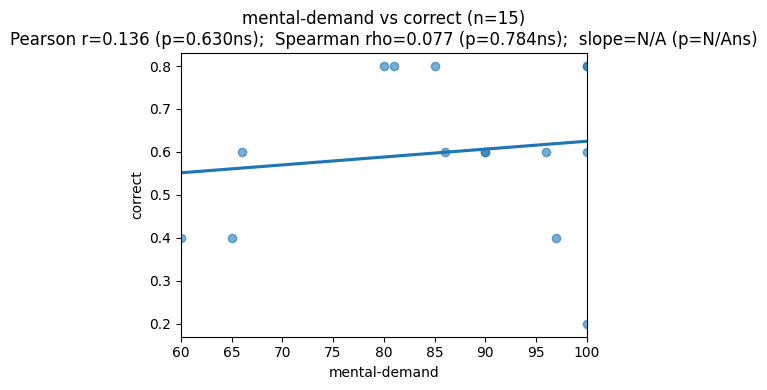

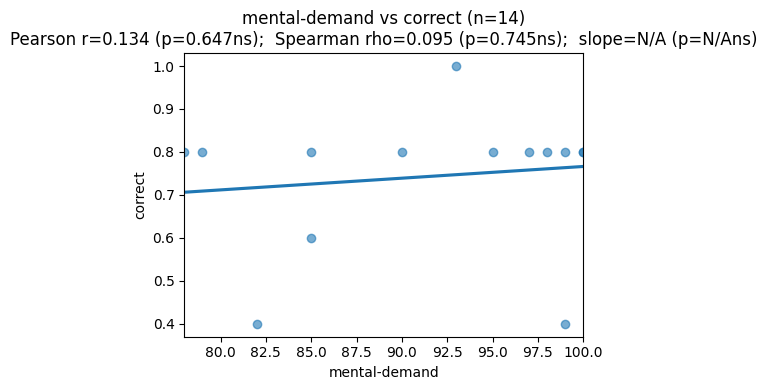

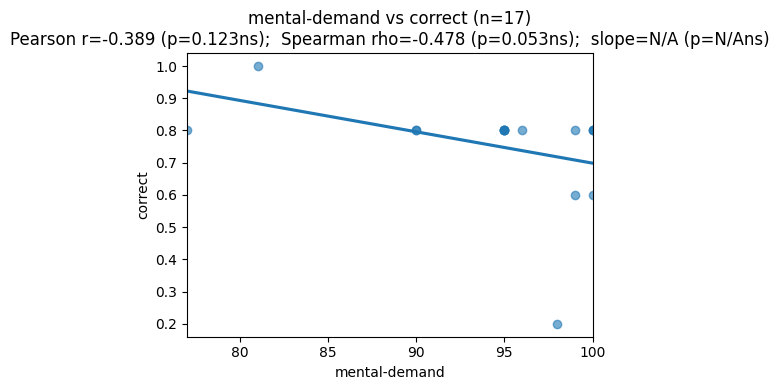

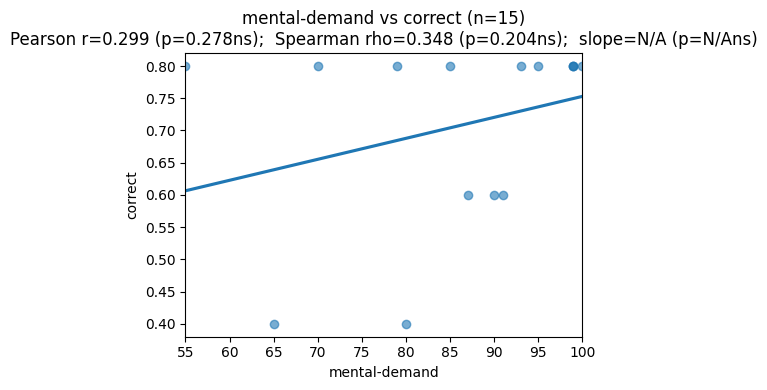

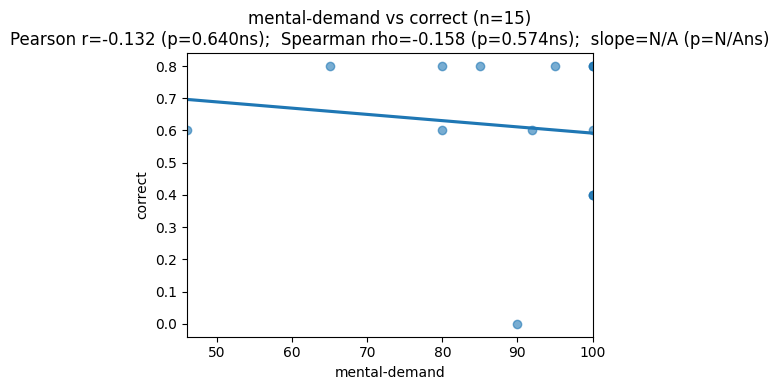

  format                                     interpretation
0  json5  n=15. Pearson r=0.462 (p=0.083ns); Spearman rh...
1  hjson  n=15. Pearson r=-0.153 (p=0.587ns); Spearman r...
2   yaml  n=15. Pearson r=0.136 (p=0.630ns); Spearman rh...
3   toml  n=14. Pearson r=0.134 (p=0.647ns); Spearman rh...
4   json  n=17. Pearson r=-0.389 (p=0.123ns); Spearman r...
5  jsonc  n=15. Pearson r=0.299 (p=0.278ns); Spearman rh...
6    xml  n=15. Pearson r=-0.132 (p=0.640ns); Spearman r...


In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pointbiserialr
import statsmodels.formula.api as smf

def summarize_and_plot_by_format(
    df_metric:       pd.DataFrame,
    df_correct:      pd.DataFrame,
    metric_col:      str = 'mental-demand',
    correct_col:     str = 'correct',
    participant_col: str = 'participantId',
    format_col:      str = 'format',
    merge_on:        list = None,
    alpha:           float = 0.05,
    figsize:         tuple = (8,6)
) -> pd.DataFrame:
    """
    1) 合并 df_metric 和 df_correct；
    2) 计算每个 format 的 Mann–Whitney U, point-biserial, logit stats；
    3) 在一张图里画出所有 format 的 scatter + regline，
       并在每组中位点位置上标注 format 名称，同时在图右侧注 p_mwu；
    返回 summary_by_format：每行一个 format，包括统计量和 interpretation。
    """
    if merge_on is None:
        merge_on = [participant_col, format_col]

    # 合并并丢弃 NA
    df = (
        pd.merge(
            df_metric[[*merge_on, metric_col]],
            df_correct[[*merge_on, correct_col]],
            on=merge_on, how='inner'
        )
        .dropna(subset=[metric_col, correct_col])
    )
    df[correct_col] = df[correct_col].astype(int)

    formats = df[format_col].unique().tolist()
    palette = sns.color_palette("tab10", n_colors=len(formats))

    # --- 可视化部分 --- #
    fig, ax = plt.subplots(figsize=figsize)
    for fmt, color in zip(formats, palette):
        sub = df[df[format_col] == fmt]
        # 1) 散点
        ax.scatter(
            sub[metric_col], sub[correct_col],
            alpha=0.6, label=fmt, color=color
        )
        # 2) 回归线
        sns.regplot(
            x=metric_col, y=correct_col, data=sub,
            ci=None, scatter=False, ax=ax, color=color
        )
        # 3) 在中位点处加标签
        x_med = sub[metric_col].median()
        y_med = sub[correct_col].median()
        ax.text(
            x_med, y_med + 0.03,  # y轴上稍微抬高一点
            fmt,
            color=color,
            fontsize= 9, 
            fontweight='bold',
            ha='center'
        )

    ax.set_xlabel(metric_col)
    ax.set_ylabel(f"P({correct_col}=1)")
    ax.set_title(f"{metric_col} vs {correct_col} by format")
    ax.legend(title=format_col, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()

    # --- 汇总统计量部分 --- #
    def safe_fmt(v, spec):
        return format(v, spec) if v is not None else "N/A"

    rows = []
    for fmt in formats:
        sub = df[df[format_col] == fmt]
        wrong = sub[sub[correct_col] == 0][metric_col]
        right = sub[sub[correct_col] == 1][metric_col]

        # Mann–Whitney U
        if len(wrong)>0 and len(right)>0:
            U, p_mwu = mannwhitneyu(wrong, right, alternative='two-sided')
        else:
            U, p_mwu = None, None

        # point‐biserial
        try:
            r_pb, p_pb = pointbiserialr(sub[correct_col], sub[metric_col])
        except:
            r_pb, p_pb = None, None

        # logistic
        try:
            m = smf.logit(f"{correct_col} ~ {metric_col}", data=sub).fit(disp=False)
            coef, p_log = m.params[metric_col], m.pvalues[metric_col]
        except:
            coef, p_log = None, None

        # 生成 interpretation
        p_mwu_s  = safe_fmt(p_mwu, ".3f")
        star     = "★" if (p_mwu is not None and p_mwu < alpha) else "ns"
        interp = (
            f"[{fmt}] MW p={p_mwu_s} ({star}); "
            f"pb r={safe_fmt(r_pb, '.3f')} (p={safe_fmt(p_pb, '.3f')}); "
            f"logit coef={safe_fmt(coef, '.3e')} (p={safe_fmt(p_log, '.3f')})"
        )

        rows.append({
            format_col:      fmt,
            'U_stat':        U,
            'p_mwu':         p_mwu,
            'r_pb':          r_pb,
            'p_pb':          p_pb,
            'logit_coef':    coef,
            'p_logit':       p_log,
            'interpretation': interp
        })

    # --- 图右侧注 p_mwu --- #
    y0 = 0.95
    dy = 0.05
    for fmt, color in zip(formats, palette):
        rec = next(r for r in rows if r[format_col] == fmt)
        p_s = safe_fmt(rec['p_mwu'], ".3f")
        star = "★" if (rec['p_mwu'] is not None and rec['p_mwu'] < alpha) else "ns"
        ax.text(
            1.02, y0,
            f"{fmt}: p={p_s} ({star})",
            transform=ax.transAxes,
            color=color
        )
        y0 -= dy

    plt.show()
    return pd.DataFrame(rows)

formats = df_nasa['format'].unique()
all_summaries = []

for fmt in formats:
    # 只挑出这个 format 下的 rows
    df_met = df_nasa   [df_nasa  ['format']==fmt]
    df_cor = df_only_aggregated[df_only_aggregated['format']==fmt]
    
    # 调用已写好的分析函数
    res = analyze_metric_vs_correct(
        df_metric  = df_met,
        df_correct = df_cor,
        metric_col = 'mental-demand',
        correct_col= 'correct',
        merge_on   = ['participantId','format'],
        figsize    = (5,4)
    )
    res['format'] = fmt
    all_summaries.append(res)

summary_by_format = pd.concat(all_summaries, ignore_index=True)
print(summary_by_format[['format','interpretation']])


In [126]:
for fmt, text in zip(summary_by_format['format'], summary_by_format['interpretation']):
    print(f"{fmt}:")
    print(text)
    print('-'*80)

json5:
n=15. Pearson r=0.462 (p=0.083ns); Spearman rho=0.185 (p=0.510ns); Linear slope=N/A (p=N/Ans).
--------------------------------------------------------------------------------
hjson:
n=15. Pearson r=-0.153 (p=0.587ns); Spearman rho=-0.225 (p=0.420ns); Linear slope=N/A (p=N/Ans).
--------------------------------------------------------------------------------
yaml:
n=15. Pearson r=0.136 (p=0.630ns); Spearman rho=0.077 (p=0.784ns); Linear slope=N/A (p=N/Ans).
--------------------------------------------------------------------------------
toml:
n=14. Pearson r=0.134 (p=0.647ns); Spearman rho=0.095 (p=0.745ns); Linear slope=N/A (p=N/Ans).
--------------------------------------------------------------------------------
json:
n=17. Pearson r=-0.389 (p=0.123ns); Spearman rho=-0.478 (p=0.053ns); Linear slope=N/A (p=N/Ans).
--------------------------------------------------------------------------------
jsonc:
n=15. Pearson r=0.299 (p=0.278ns); Spearman rho=0.348 (p=0.204ns); Linear slo

In [92]:
def filter_tasks_by_prefix(
    df: pd.DataFrame,
    prefixes,
    task_col: str = 'task'
) -> pd.DataFrame:
    """
    提取 df 中 task_col 列以某些前缀开头的所有行。

    参数
    ----
    df : pd.DataFrame
      原始表格。
    prefixes : str 或 list/tuple of str
      单个前缀，或一组前缀。例如 'reading-task-tabular'，或 ['reading-task-tabular','modifying-task']。
    task_col : str
      存储任务名称的列名，默认 'task'。

    返回
    ----
    pd.DataFrame
      只保留那些 task_col 值以任一前缀开头的行（并 reset_index）。
    """
    # 确保 prefixes 是可迭代的字符串列表
    if isinstance(prefixes, str):
        prefixes = [prefixes]
    prefixes = tuple(prefixes)

    mask = df[task_col].str.startswith(prefixes)
    return df[mask].reset_index(drop=True)

df_reading_tabular = filter_tasks_by_prefix(
    df_post_clean,
    prefixes='reading-task-tabular',
    task_col='task'
)